<a href="https://colab.research.google.com/github/LisaHoek/TxMM-PawpularityContest/blob/main/TxMM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TxMM Project - Pawpularity Contest
## Part III Analysis Vision API labels
Author: Lisa Hoek, contact at lisa.hoek@ru.nl

In [1]:
import os
import re
import csv
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scipy.stats as st

colors = ["#7783de","#6cca4f","#b96ade","#ccd652","#e34db1","#7fde9f","#de606c",
"#82cac4","#e36936","#729cbf","#c89c43","#cea9db","#72985a","#c57c9a","#c7a98c"]

In [2]:
# I created the dataset in parts in the previous notebook due to its runtime, let's read it into one dataframe
data0 = pd.read_csv('/content/drive/MyDrive/TxMM/data-0.csv', index_col=0)
data12 = pd.read_csv('/content/drive/MyDrive/TxMM/data-12.csv', index_col=0)
data34 = pd.read_csv('/content/drive/MyDrive/TxMM/data-34.csv', index_col=0)
data5678 = pd.read_csv('/content/drive/MyDrive/TxMM/data-5678.csv', index_col=0)
data9 = pd.read_csv('/content/drive/MyDrive/TxMM/data-9.csv', index_col=0)

In [3]:
data = data0.append(data12).append(data34).append(data5678).append(data9)
data.head()

Id  Pawpularity        Feature  Score
11  00524dbf2637a80cbc80f70d3ff59616            2            Dog  96.24
11  00524dbf2637a80cbc80f70d3ff59616            2      Carnivore  88.87
11  00524dbf2637a80cbc80f70d3ff59616            2      Dog breed  88.67
11  00524dbf2637a80cbc80f70d3ff59616            2           Fawn  81.56
11  00524dbf2637a80cbc80f70d3ff59616            2  Companion dog  81.51

In [4]:
# Calculates for a bin the normalised sum and sum, if feature is not in a certain bin, it returns zero.
def get_feature(c, i, j, feature, df):
  mask1 = (df['Pawpularity'] >= i) & (df['Pawpularity'] <= j)
  df2 = df.loc[mask1]
  mask2 = (df2['Feature'] == feature)
  df3 = df2.loc[mask2]
  wordfreqlist = list(zip(df3.Feature, df3.Score))
  wordfreq = {}
  wordfreqn = {}
  for feature, score in wordfreqlist:
    percentage = wordfreqn.get(feature, 0) + score
    sum = wordfreq.get(feature, 0) + 1
    wordfreqn[feature] = round(percentage,2) 
    wordfreq[feature] = sum
  if wordfreqn.get(feature) is not None:
    return (c, wordfreqn[feature]/df2['Id'].nunique(), wordfreq[feature])
  else:
    return (c, 0, 0)

# Creates list with tuple (bin, normalised sum, sum) in 100 bins.
def analyse_feature_100(feature, df):
  values = []
  for i in range(0,100):
    value = get_feature(i, 1+1*i, 1+1*i, feature, df)
    values.append(value)
  return values

# Creates list with tuple (bin, normalised sum, sum) in 20 bins.
def analyse_feature_20(feature, df):
  values = []
  for i in range(0,20):
    value = get_feature(i, 1+5*i, 5+5*i, feature, df)
    values.append(value)
  return values

# Creates list with tuple (bin, normalised sum, sum) in 10 bins.
def analyse_feature_10(feature, df):
  values = []
  for i in range(0,10):
    value = get_feature(i, 1+10*i, 10+10*i, feature, df)
    values.append(value)
  return values

# Indicates whether feature has less than 10 datapoints
def too_small(data):
  if sum(x[2] for x in data) < 10:
    return True
  return False

In [5]:
analyse_feature_20('Cat', data)

[(0, 36.786016597510375, 94),
 (1, 57.619268292682925, 100),
 (2, 59.420787172011664, 216),
 (3, 59.809970104633784, 423),
 (4, 59.06247338247338, 763),
 (5, 58.85456996148909, 969),
 (6, 53.25773203592814, 752),
 (7, 50.051065737051786, 532),
 (8, 49.96561538461538, 414),
 (9, 44.48068610634649, 275),
 (10, 42.50508599508599, 183),
 (11, 38.31701257861635, 129),
 (12, 34.979657794676804, 97),
 (13, 41.428156424581005, 79),
 (14, 31.95574850299401, 57),
 (15, 36.16288135593221, 45),
 (16, 24.756060606060604, 26),
 (17, 32.92635135135136, 26),
 (18, 31.666969696969698, 22),
 (19, 21.955900621118012, 75)]

In [6]:
analyse_feature_10('Cat', data)

[(0, 45.2221975308642, 194),
 (1, 59.67806324110671, 639),
 (2, 58.9459157970493, 1732),
 (3, 51.88188034188035, 1284),
 (4, 47.61953044754218, 689),
 (5, 40.66811034482759, 312),
 (6, 37.59115384615385, 176),
 (7, 33.697649122807015, 102),
 (8, 28.250867052023118, 52),
 (9, 23.60778350515464, 97)]

In [38]:
# Function to plot the normalised sum in a bar chart with its number of (not normalised) datapoints at the bottom
# It also prints the Pearson Correlation Coefficient
def feature_plot_100(feature, data, color, ymin, ymax):
    values = analyse_feature_100(feature, data)
    xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]
    fig, ax = plt.subplots(1,1,figsize=(15, 5))
    plt.bar(xy[0], xy[1], label=feature, color=color, align='edge', width=1, edgecolor='black')
    plt.xlabel('Pawpularity score')
    plt.ylabel('% feature found')
    plt.axis([0, 100, ymin, ymax])
    plt.rc('font', size=20)
    plt.legend(loc='upper right')
    plt.show()
    corr, _ = pearsonr(xy[0], xy[1])
    stest = ttest_ind(xy[0], xy[1])
    conf = st.norm.interval(alpha=0.95, loc=np.mean(xy[0]), scale=st.sem(xy[0]))
    print("Data points:", sum(xy[2]))
    print("Pearsons correlation: %.3f" % corr)
    print("P-value: %.3f" % stest.pvalue)

def feature_plot(feature, data, color, ymin, ymax):
    values = analyse_feature_20(feature, data)
    xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]
    fig, ax = plt.subplots(1,1,figsize=(15, 5))
    plt.bar(xy[0], xy[1], label=feature, color=color, align='edge', width=1, edgecolor='black')
    plt.xlabel('Pawpularity score')
    plt.ylabel('% feature found')
    plt.axis([0, 20, ymin, ymax])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
               labels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
    plt.rc('font', size=20)
    for i in xy[0]:
      plt.text(i, 0, xy[2][i])
    plt.legend(loc='upper right')
    plt.show()
    corr, _ = pearsonr(xy[0], xy[1])
    stest = ttest_ind(xy[0], xy[1])
    print("Data points:", sum(xy[2]))
    print("Pearsons correlation: %.3f" % corr)
    print("P-value: %.3f" % stest.pvalue)

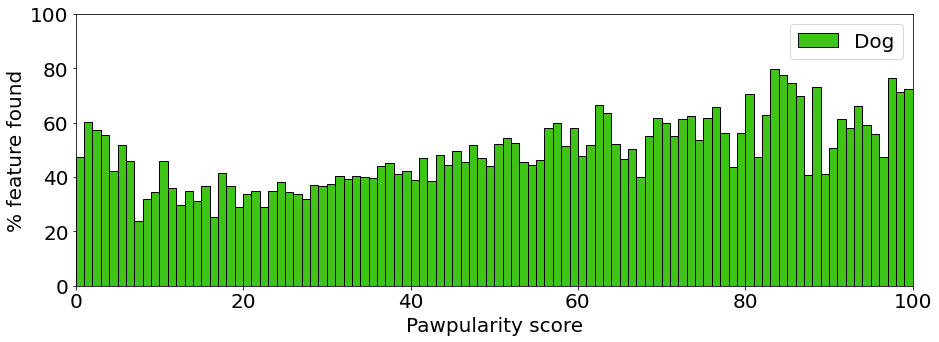

Data points: 4447
Pearsons correlation: 0.702
P-value: 0.870


In [39]:
feature_plot_100('Dog', data, '#3EC317', 0, 100)

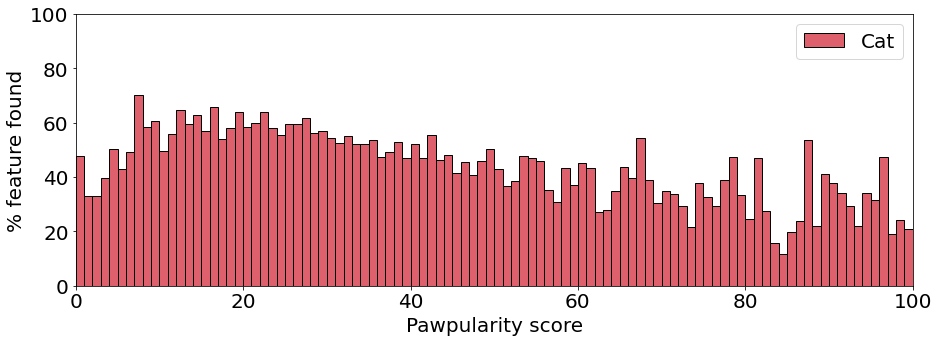

Data points: 5277
Pearsons correlation: -0.730
P-value: 0.072


In [40]:
feature_plot_100('Cat', data, '#de606c', 0, 100)

So, dogs are more popular than cats.
For the dog and cat breeds, this influences the correlation. So, we will remove this confounder by splitting the dataset in a cats and a dogs dataset based of where the label 'cat' and 'dog' is found.


In [10]:
display(data)

Id  Pawpularity             Feature  Score
11    00524dbf2637a80cbc80f70d3ff59616            2                 Dog  96.24
11    00524dbf2637a80cbc80f70d3ff59616            2           Carnivore  88.87
11    00524dbf2637a80cbc80f70d3ff59616            2           Dog breed  88.67
11    00524dbf2637a80cbc80f70d3ff59616            2                Fawn  81.56
11    00524dbf2637a80cbc80f70d3ff59616            2       Companion dog  81.51
...                                ...          ...                 ...    ...
9878  fedb56afb73e703dbcad66406943b45f          100              Square  56.33
9878  fedb56afb73e703dbcad66406943b45f          100                Door  55.53
9878  fedb56afb73e703dbcad66406943b45f          100            Wildlife  53.54
9878  fedb56afb73e703dbcad66406943b45f          100  Ancient dog breeds  51.04
9878  fedb56afb73e703dbcad66406943b45f          100   Outdoor furniture  50.74

[212913 rows x 4 columns]

In [11]:
cats_ids = data.loc[data['Feature'] == 'Cat']['Id'].tolist()
cats_data = data[data['Id'].isin(cats_ids)]
display(cats_data)

Id  Pawpularity             Feature  Score
125   038dcf0921e7ca7555a5b8e06b5deb29            3                 Cat  93.55
125   038dcf0921e7ca7555a5b8e06b5deb29            3             Comfort  88.42
125   038dcf0921e7ca7555a5b8e06b5deb29            3           Carnivore  85.89
125   038dcf0921e7ca7555a5b8e06b5deb29            3                Grey  84.37
125   038dcf0921e7ca7555a5b8e06b5deb29            3             Felidae  83.85
...                                ...          ...                 ...    ...
9599  f7d14afc9f6ddddbd56c0c494489c5a5          100                 Paw  65.38
9599  f7d14afc9f6ddddbd56c0c494489c5a5          100  Terrestrial animal  64.46
9599  f7d14afc9f6ddddbd56c0c494489c5a5          100                Claw  61.07
9599  f7d14afc9f6ddddbd56c0c494489c5a5          100            Flooring  59.07
9599  f7d14afc9f6ddddbd56c0c494489c5a5          100      Working animal  52.43

[105490 rows x 4 columns]

In [12]:
dogs_ids = data.loc[data['Feature'] == 'Dog']['Id'].tolist()
dogs_data = data[data['Id'].isin(dogs_ids)]
display(dogs_data)

Id  Pawpularity             Feature  Score
11    00524dbf2637a80cbc80f70d3ff59616            2                 Dog  96.24
11    00524dbf2637a80cbc80f70d3ff59616            2           Carnivore  88.87
11    00524dbf2637a80cbc80f70d3ff59616            2           Dog breed  88.67
11    00524dbf2637a80cbc80f70d3ff59616            2                Fawn  81.56
11    00524dbf2637a80cbc80f70d3ff59616            2       Companion dog  81.51
...                                ...          ...                 ...    ...
9878  fedb56afb73e703dbcad66406943b45f          100              Square  56.33
9878  fedb56afb73e703dbcad66406943b45f          100                Door  55.53
9878  fedb56afb73e703dbcad66406943b45f          100            Wildlife  53.54
9878  fedb56afb73e703dbcad66406943b45f          100  Ancient dog breeds  51.04
9878  fedb56afb73e703dbcad66406943b45f          100   Outdoor furniture  50.74

[102947 rows x 4 columns]

As can be seen, the correlation of 'Dog' in the dogs dataset now disappears, as whether a dog is in the picture should not increase nor decrease the popularity of the dog.

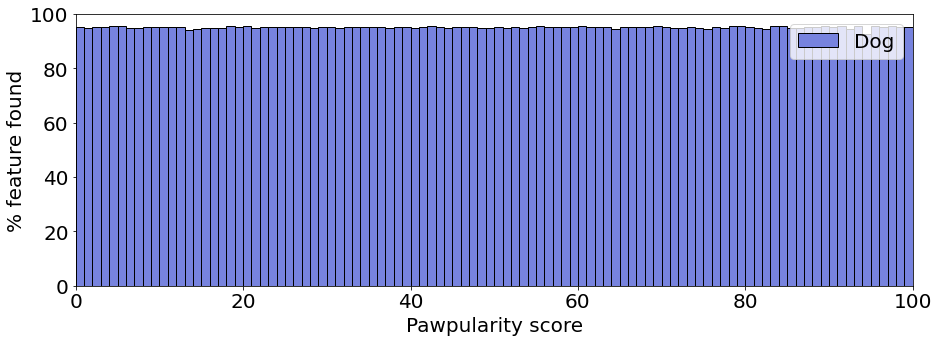

Data points: 4447
Pearsons correlation: 0.004
P-value: 0.000


In [41]:
feature_plot_100('Dog', dogs_data, colors[0], 0, 100)

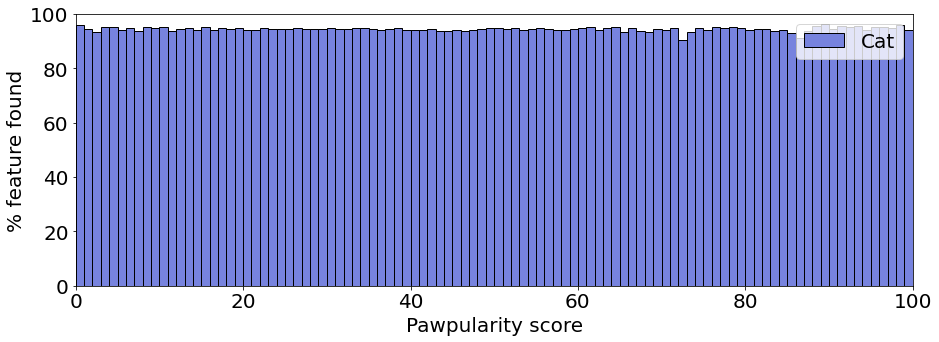

Data points: 5277
Pearsons correlation: -0.032
P-value: 0.000


In [42]:
feature_plot_100('Cat', cats_data, colors[0], 0, 100)

In [14]:
# Manually extracted cats and dogs list from the retrieved top-50 labels (breeds with less than 10 images omitted)
cats = ['Balinese', 'Birman', 'Black cat', 'Bombay', 'British longhair', 'Cat', 'Chartreux', 
        'Devon rex',  'Domestic short-haired cat', 'Havana brown', 'Korat', 'Maine coon', 
        'Oriental shorthair', 'Ragdoll', 'Russian blue', 'Siamese', 'Tonkinese']

dogs = ['Beagle', 'Beagle-harrier', 'Beaglier', 'Belgian shepherd malinois', 'Bichon', 
        'Biewer terrier', 'Borador', 'Border collie', 'Boston terrier', 'Bulldog', 
        'Carlin pinscher', 'Chihuahua', 'Cockapoo', 'Companion dog', 'Corgi-chihuahua', 
        'Dobermann', 'Dog', 'Dogo guatemalteco', 'East-european shepherd', 'German shepherd dog', 
        'German spitz', 'Golden retriever', 'Goldendoodle', 'Guard dog', 'Gun dog', 
        'Herding dog', 'Hound', 'Hunting dog', 'Irishjacks', 'King shepherd', 'Labradoodle', 
        'Labrador retriever', 'Mal-shi', 'Maltepoo', 'Molosser',  'Montenegrin mountain hound', 
        'Old german shepherd dog', 'Pinscher', 'Plott hound', 'Pomeranian', 'Poodle', 
        'Poodle crossbreed', 'Pražský krysařík', 'Pug', 'Puggle', 'Puppy', 'Rampur greyhound', 
        'Retriever', 'Rottweiler', 'Scent hound', 'Schnauzer', 'Shih tzu', 'Shih-poo', 
        'Siberian husky', 'Sighthound',  'Sled dog', 'Small terrier', 'Spaniel', 'Spitz', 
        'Standard Poodle', 'Street dog', 'Terrier', 'Texas heeler', 'Tibetan terrier', 'Toy dog',
        'Water dog', 'Working dog', 'Working terrier', 'Yorkipoo']

In [16]:
too_small(analyse_feature_20('Bull terrier', data))

True

In [15]:
# Automated version of feature_plot
def auto_feature_plot(feature, data):
    values = analyse_feature_20(feature, data)
    if not too_small(values):
      xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]
      fig, ax = plt.subplots(1,1,figsize=(12, 5))
      plt.bar(xy[0], xy[1], label=feature, align='edge', width=1, edgecolor='black')
      plt.xlabel('Pawpularity class')
      plt.ylabel('% feature found')
      plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
               labels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
      plt.rc('font', size=20)
      for i in xy[0]:
        plt.text(i, 0, xy[2][i])
      plt.legend(loc='upper right')
      plt.show()
      corr, _ = pearsonr(xy[0], xy[1])
      stest = ttest_ind(xy[0], xy[1])
      print("Pearsons correlation: %.3f" % corr)
      print("P-value: %.3f" % stest.pvalue)

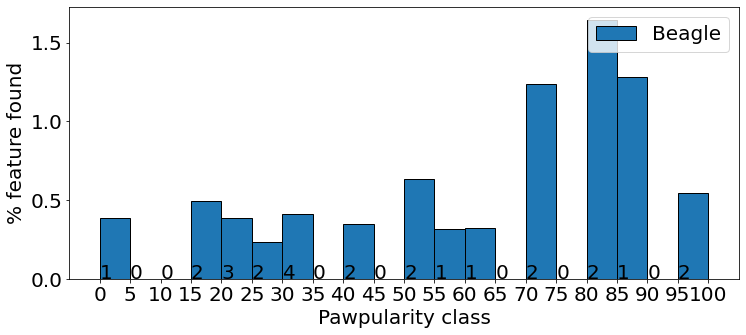

Pearsons correlation: 0.388
P-value: 0.000


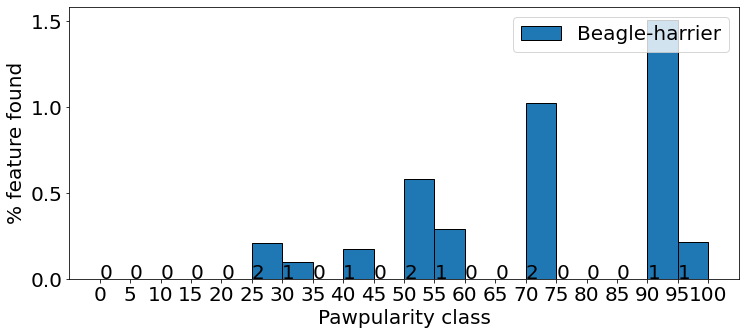

Pearsons correlation: 0.415
P-value: 0.000


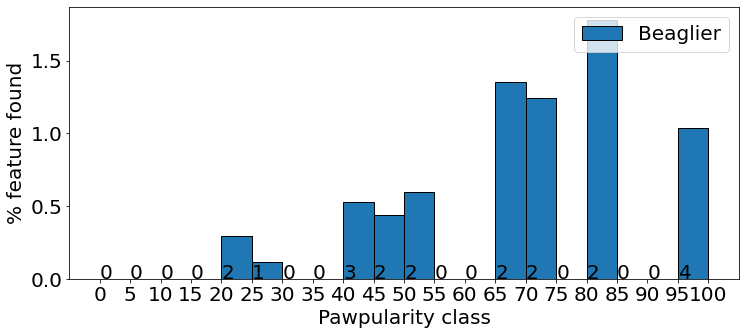

Pearsons correlation: 0.465
P-value: 0.000


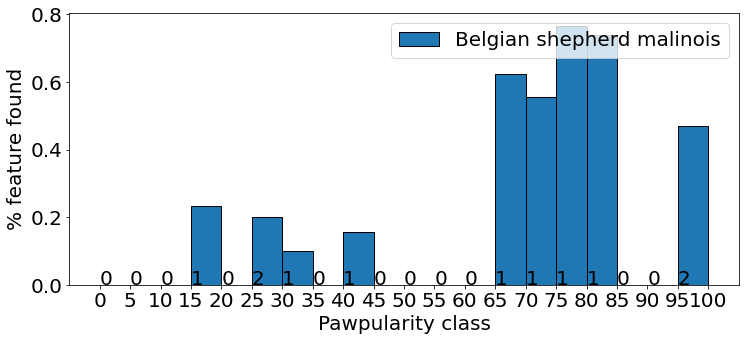

Pearsons correlation: 0.490
P-value: 0.000


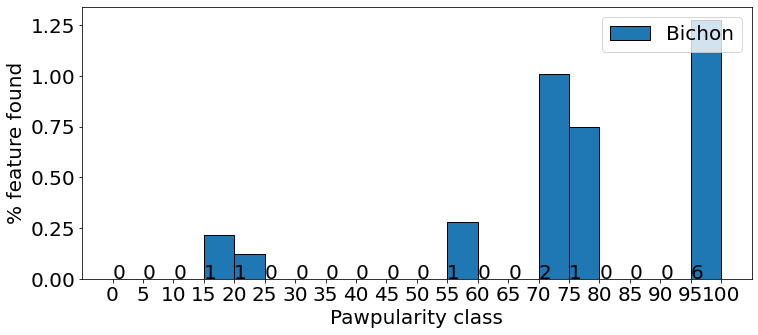

Pearsons correlation: 0.452
P-value: 0.000


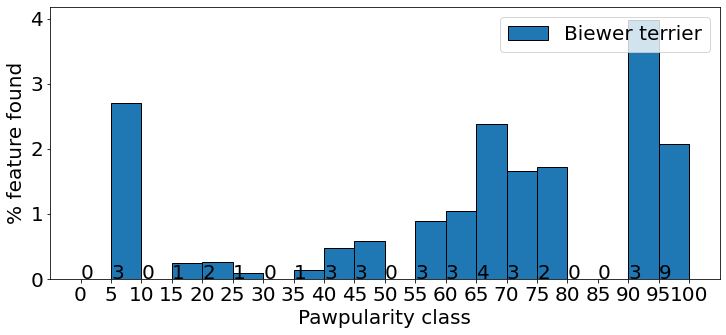

Pearsons correlation: 0.429
P-value: 0.000


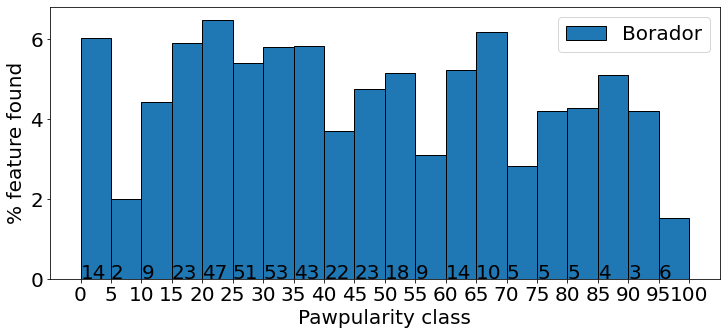

Pearsons correlation: -0.348
P-value: 0.001


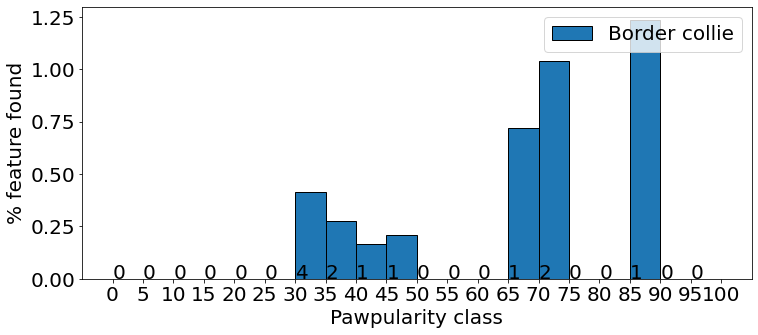

Pearsons correlation: 0.335
P-value: 0.000


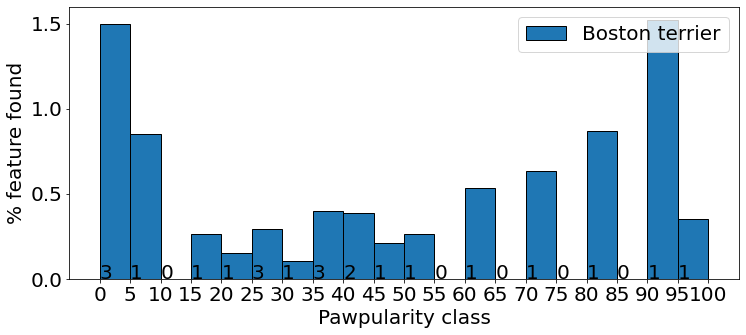

Pearsons correlation: -0.022
P-value: 0.000


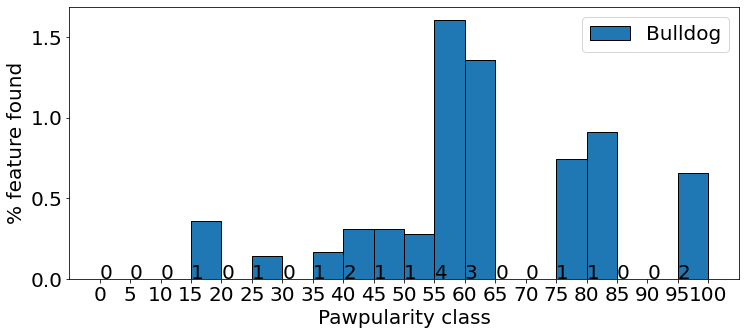

Pearsons correlation: 0.338
P-value: 0.000


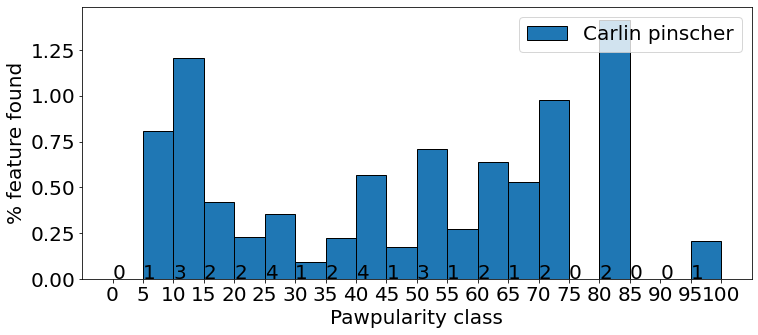

Pearsons correlation: -0.077
P-value: 0.000


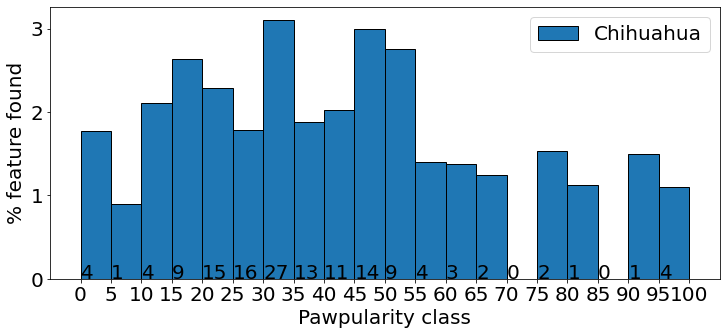

Pearsons correlation: -0.499
P-value: 0.000


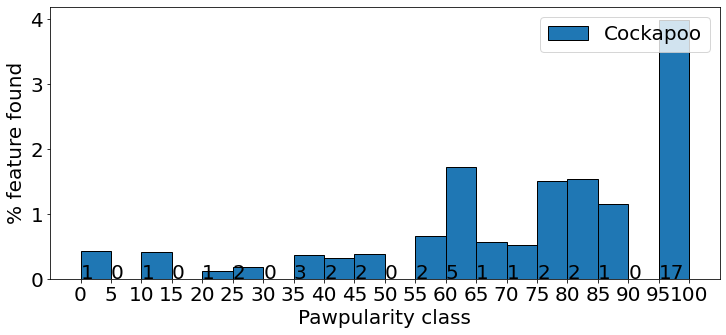

Pearsons correlation: 0.603
P-value: 0.000


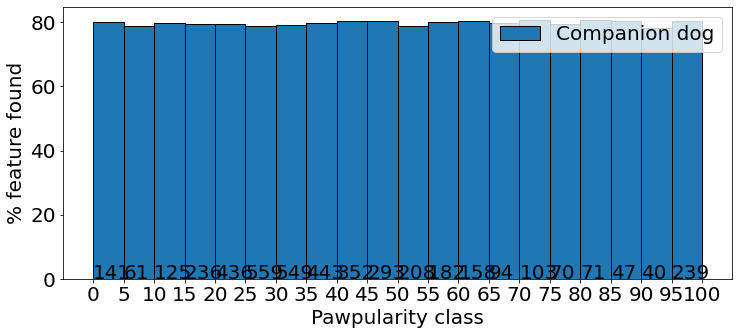

Pearsons correlation: 0.281
P-value: 0.000


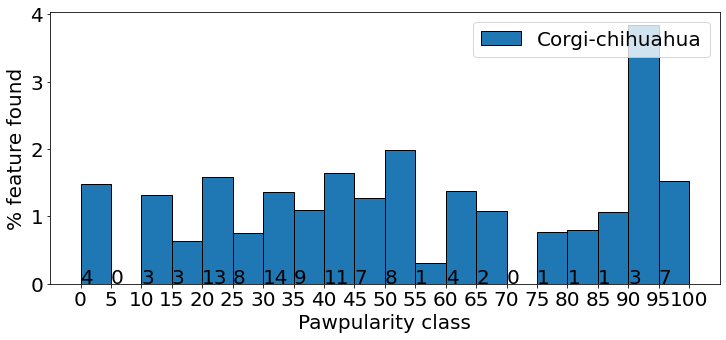

Pearsons correlation: 0.245
P-value: 0.000


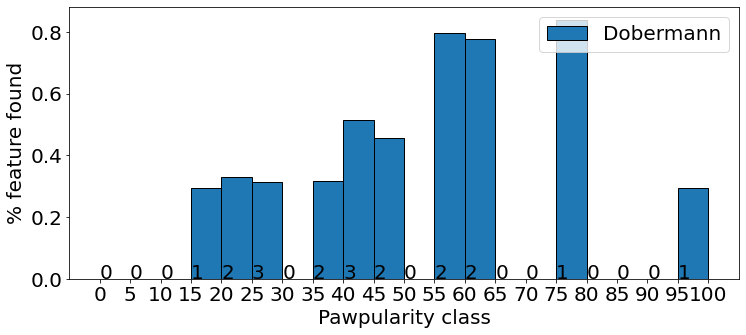

Pearsons correlation: 0.108
P-value: 0.000


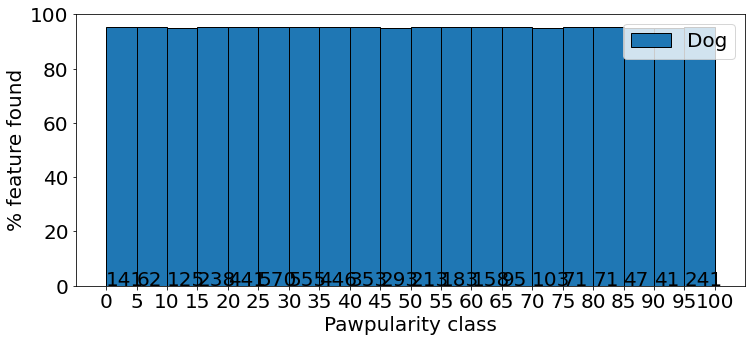

Pearsons correlation: -0.130
P-value: 0.000


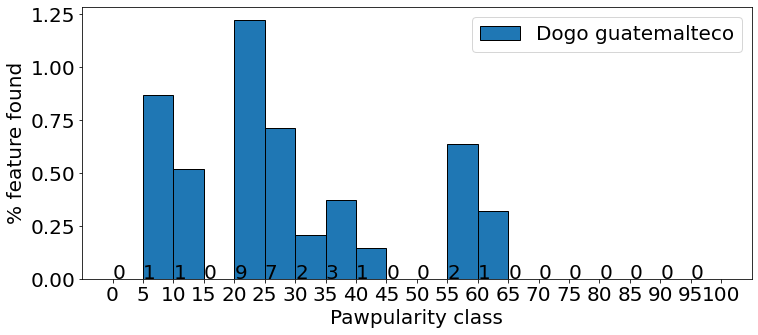

Pearsons correlation: -0.524
P-value: 0.000


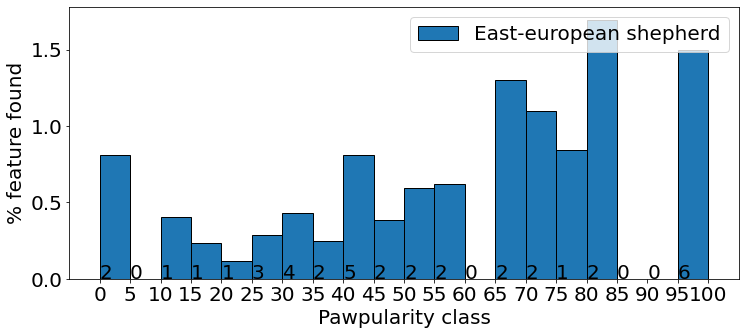

Pearsons correlation: 0.397
P-value: 0.000


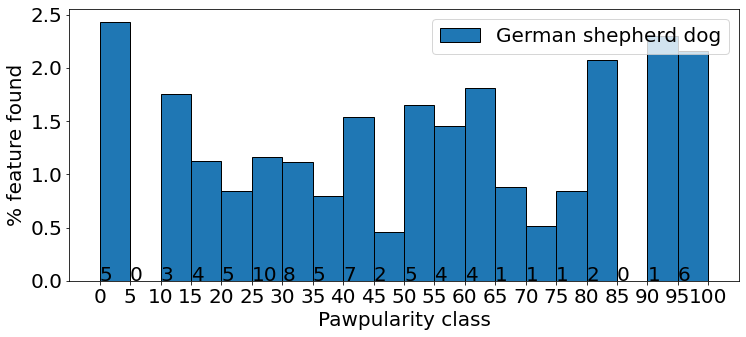

Pearsons correlation: 0.114
P-value: 0.000


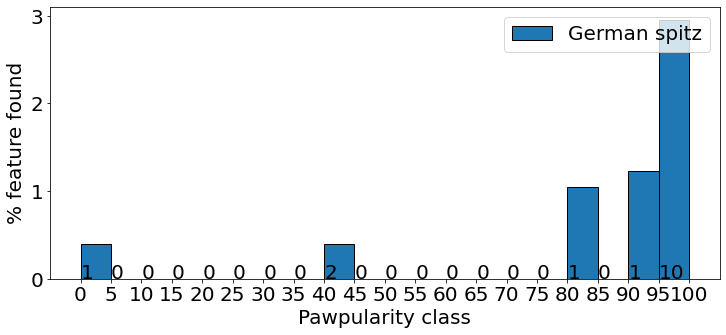

Pearsons correlation: 0.507
P-value: 0.000


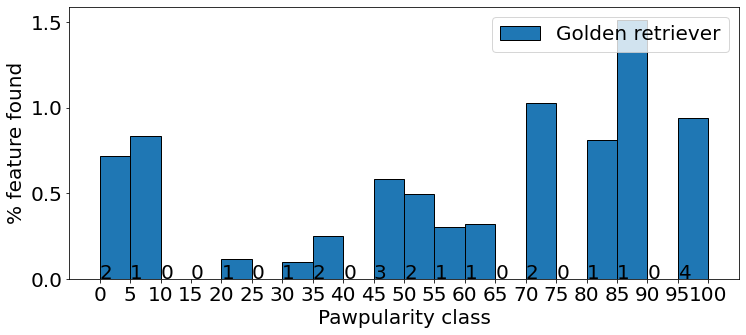

Pearsons correlation: 0.318
P-value: 0.000


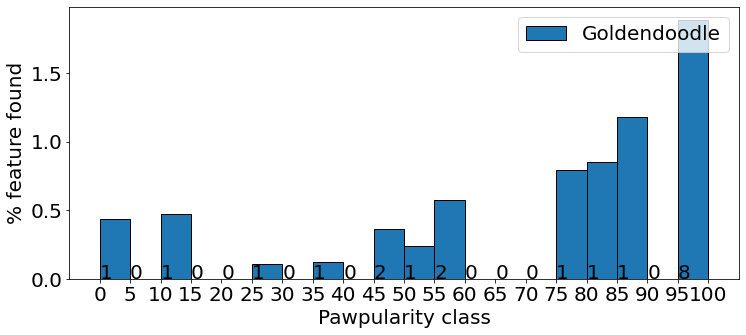

Pearsons correlation: 0.513
P-value: 0.000


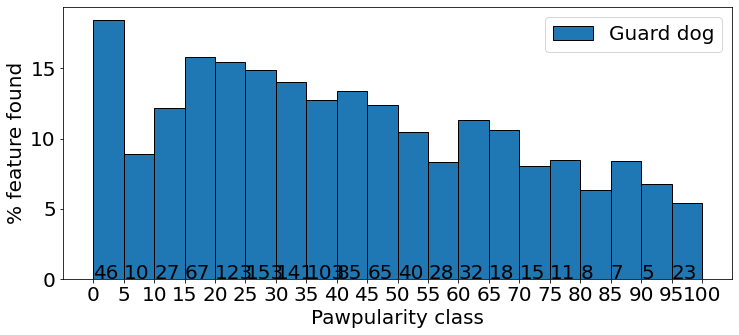

Pearsons correlation: -0.815
P-value: 0.301


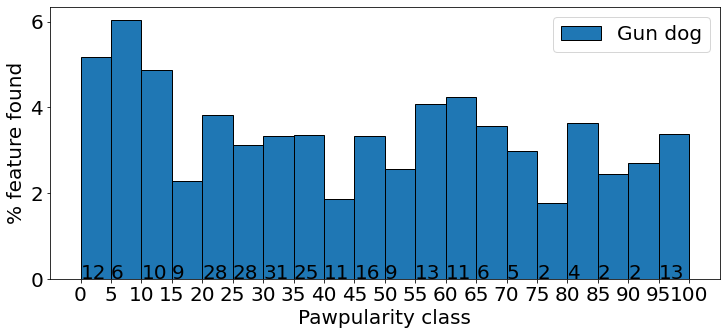

Pearsons correlation: -0.501
P-value: 0.000


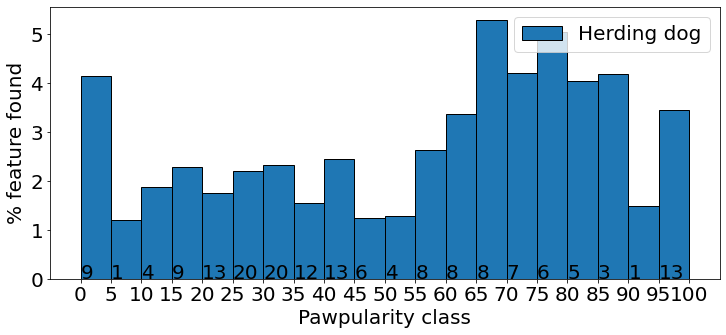

Pearsons correlation: 0.454
P-value: 0.000


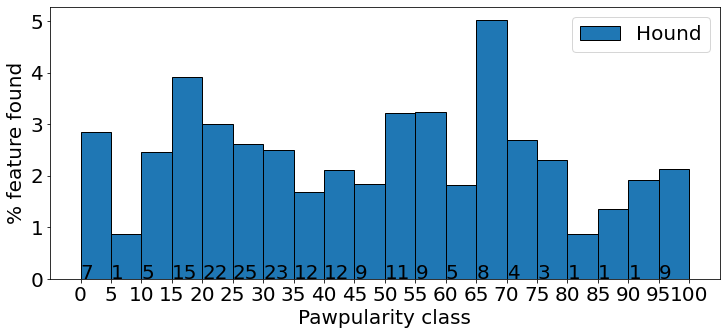

Pearsons correlation: -0.163
P-value: 0.000


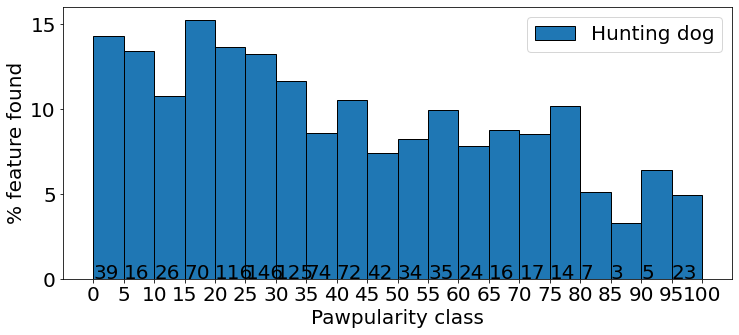

Pearsons correlation: -0.867
P-value: 0.947


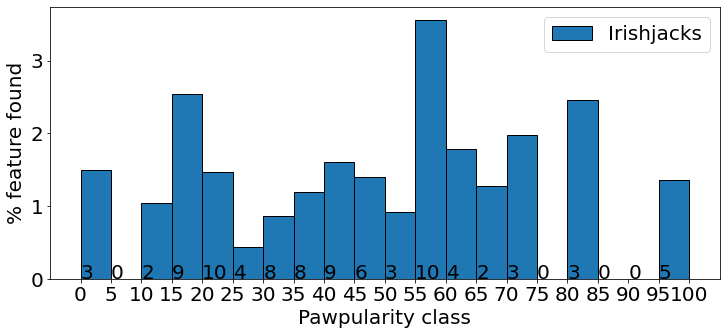

Pearsons correlation: -0.049
P-value: 0.000


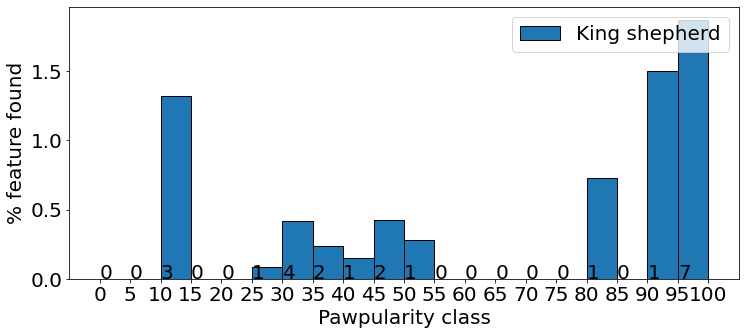

Pearsons correlation: 0.356
P-value: 0.000


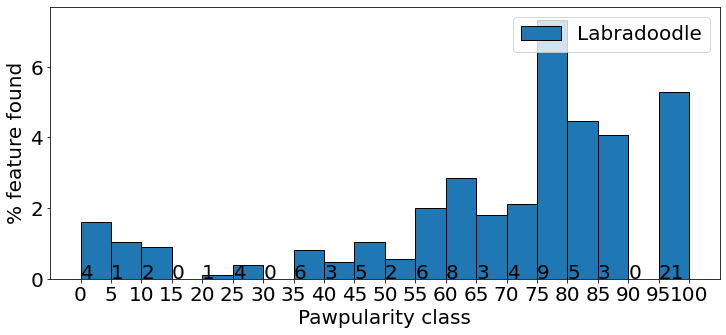

Pearsons correlation: 0.618
P-value: 0.000


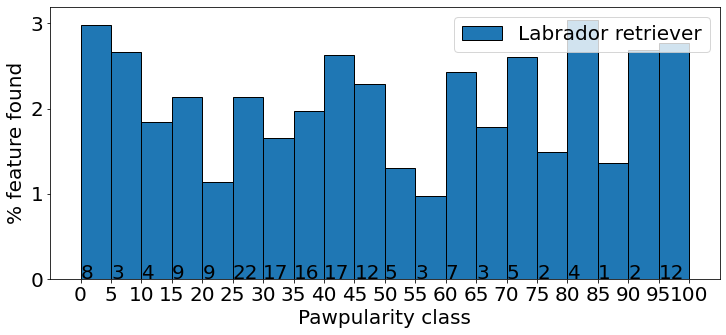

Pearsons correlation: 0.046
P-value: 0.000


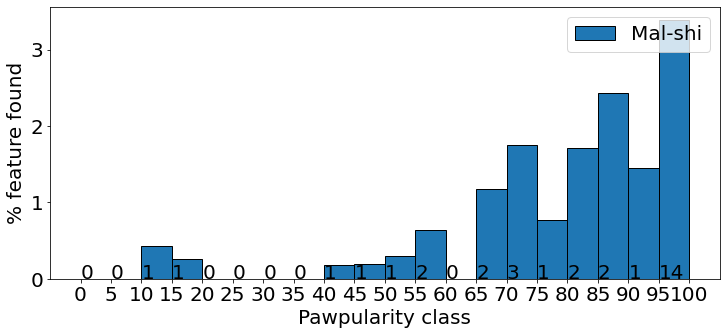

Pearsons correlation: 0.796
P-value: 0.000


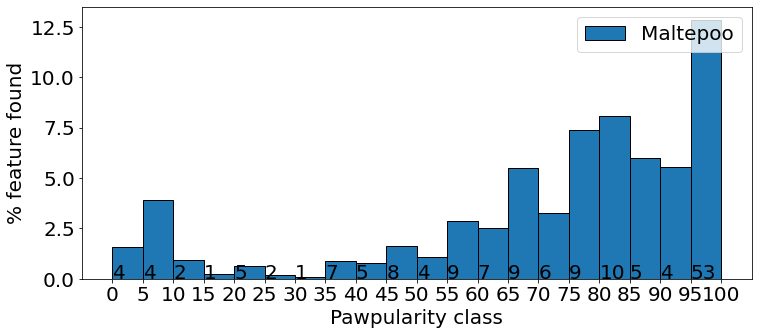

Pearsons correlation: 0.761
P-value: 0.000


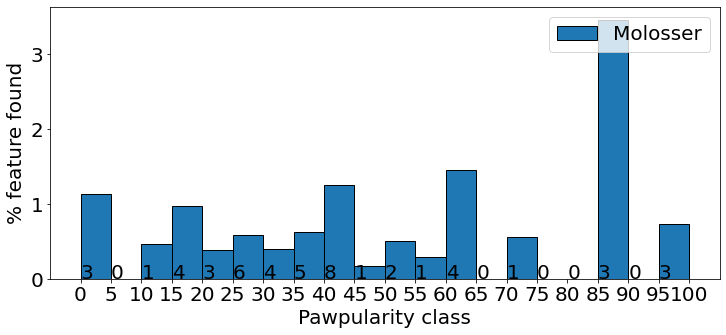

Pearsons correlation: 0.105
P-value: 0.000


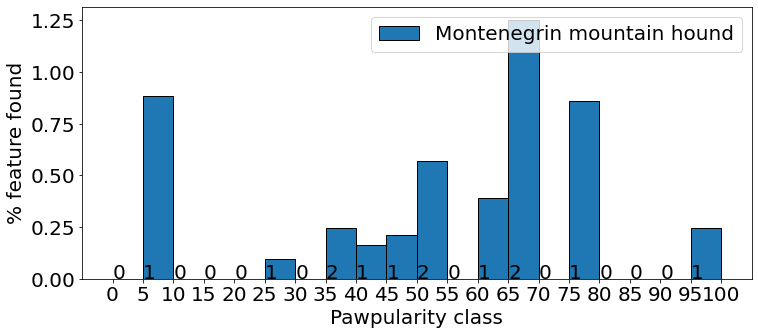

Pearsons correlation: 0.091
P-value: 0.000


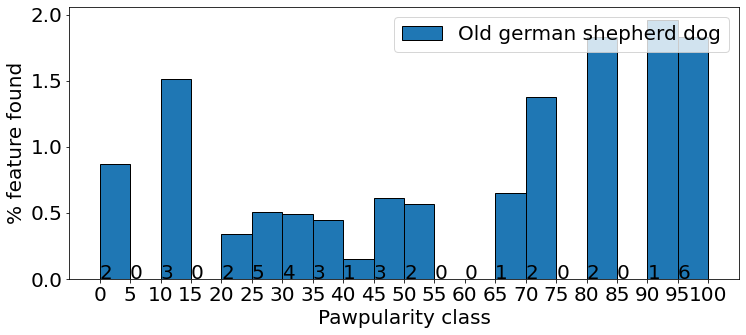

Pearsons correlation: 0.361
P-value: 0.000


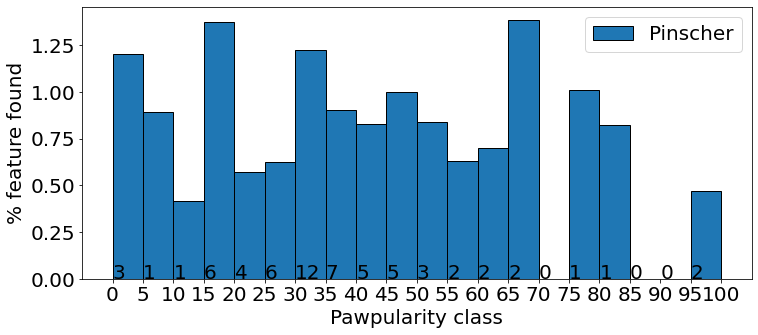

Pearsons correlation: -0.465
P-value: 0.000


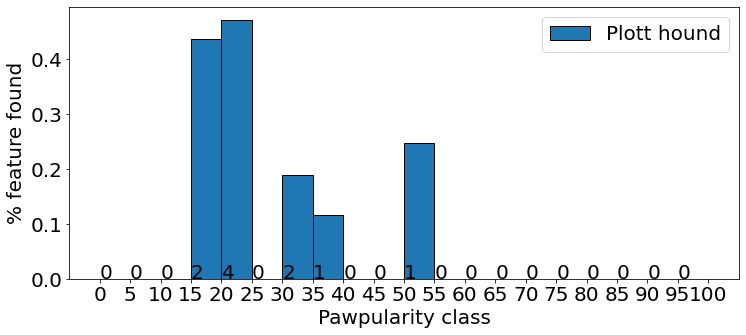

Pearsons correlation: -0.376
P-value: 0.000


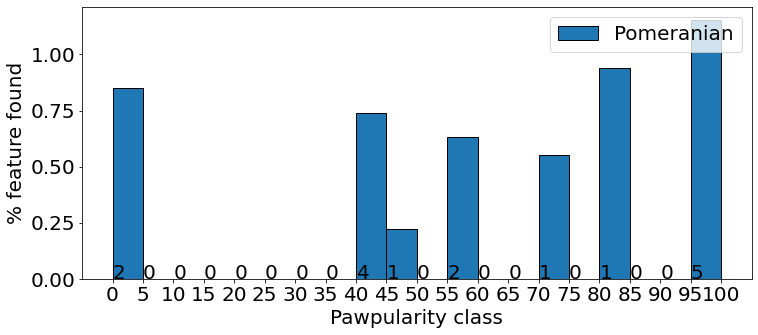

Pearsons correlation: 0.253
P-value: 0.000


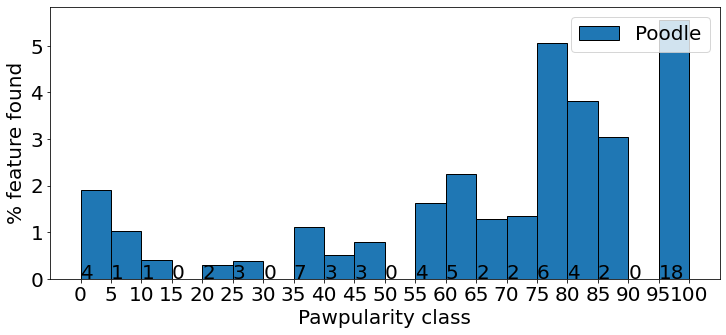

Pearsons correlation: 0.587
P-value: 0.000


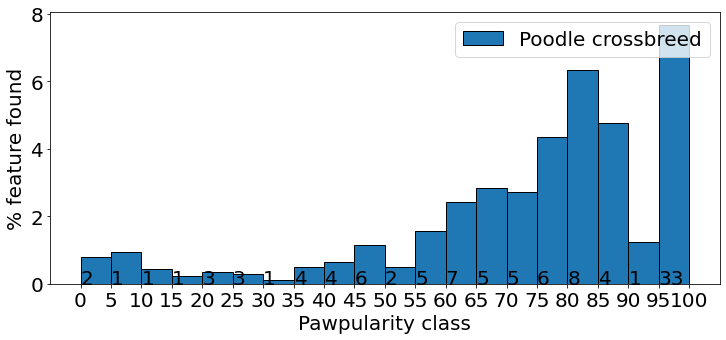

Pearsons correlation: 0.766
P-value: 0.000


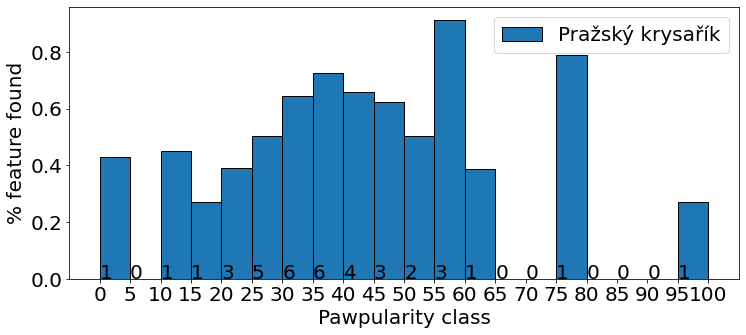

Pearsons correlation: -0.283
P-value: 0.000


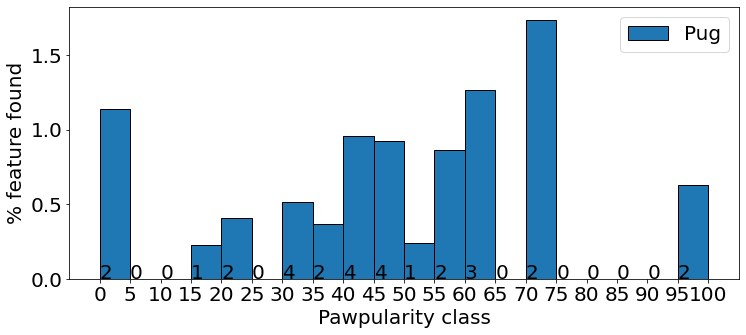

Pearsons correlation: -0.013
P-value: 0.000


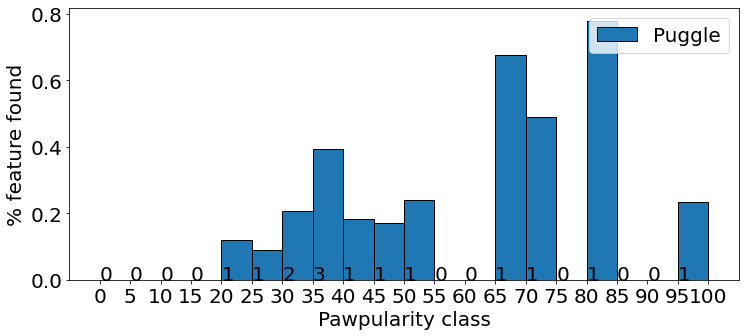

Pearsons correlation: 0.334
P-value: 0.000


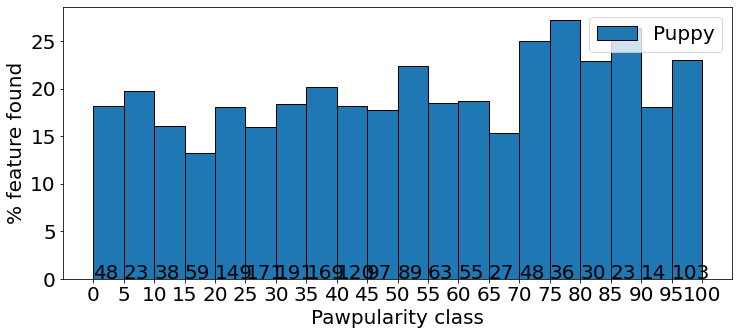

Pearsons correlation: 0.598
P-value: 0.000


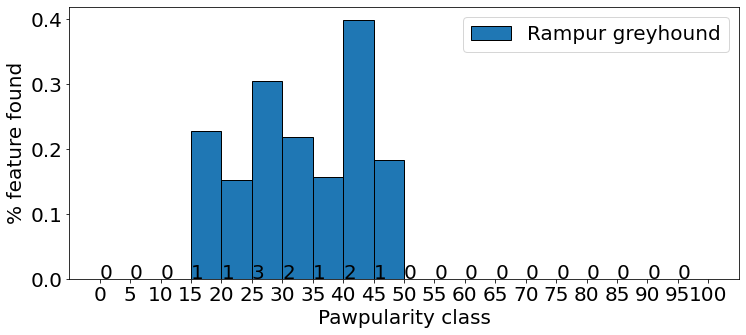

Pearsons correlation: -0.394
P-value: 0.000


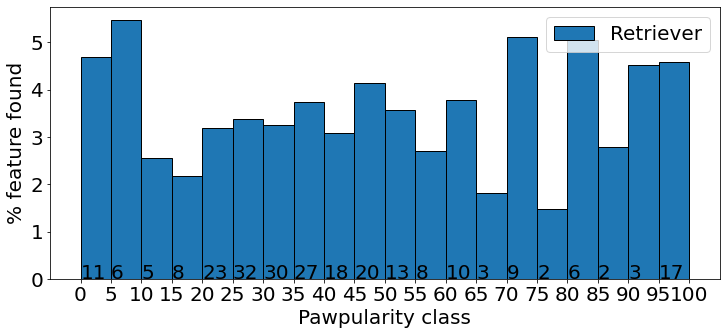

Pearsons correlation: 0.032
P-value: 0.000


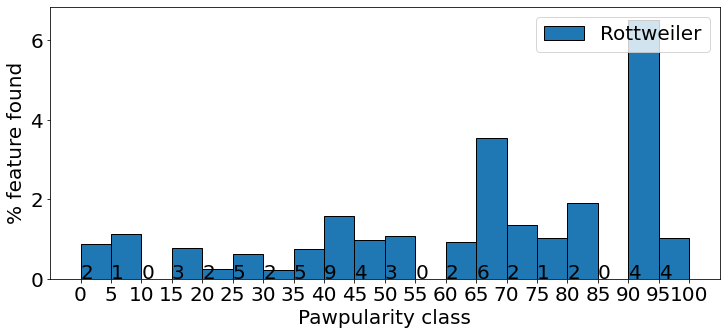

Pearsons correlation: 0.431
P-value: 0.000


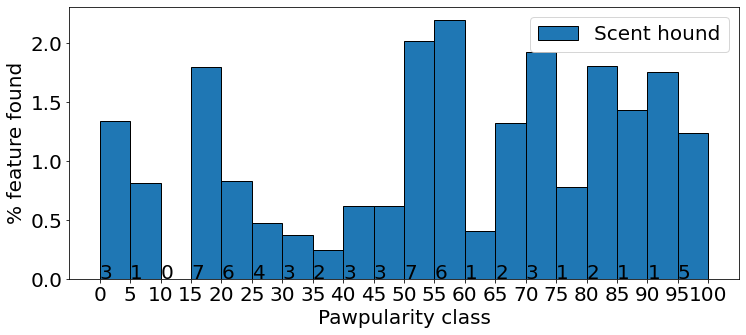

Pearsons correlation: 0.412
P-value: 0.000


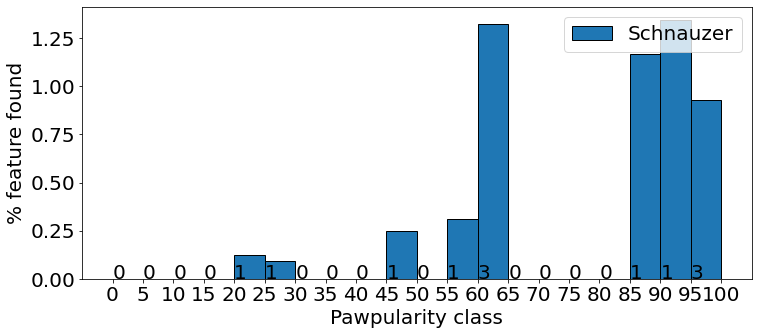

Pearsons correlation: 0.582
P-value: 0.000


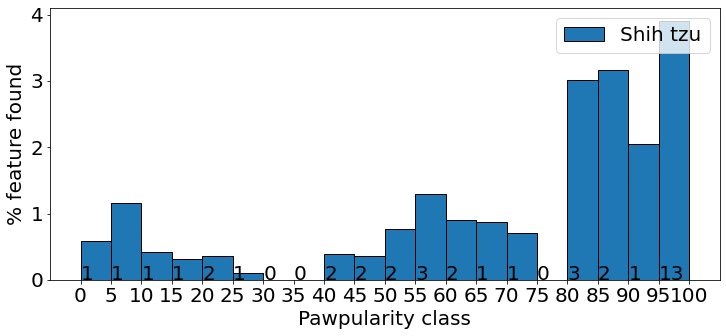

Pearsons correlation: 0.664
P-value: 0.000


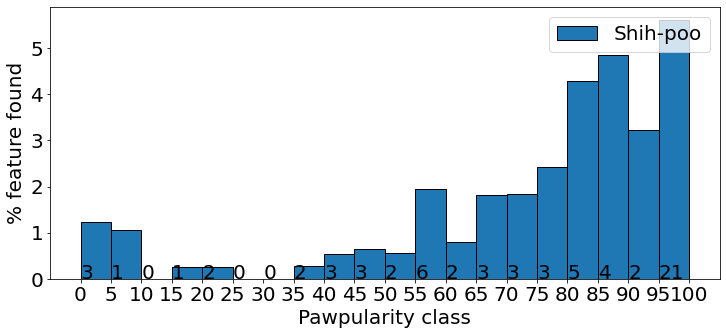

Pearsons correlation: 0.800
P-value: 0.000


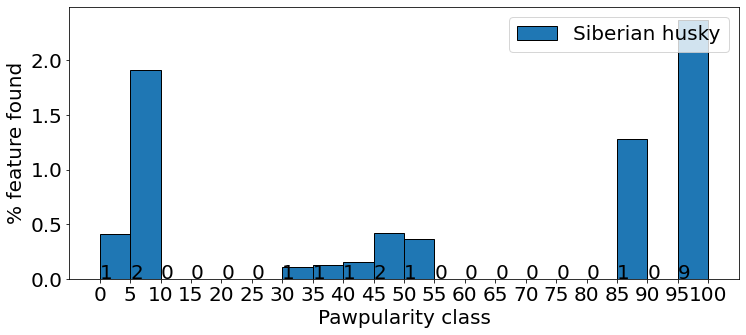

Pearsons correlation: 0.143
P-value: 0.000


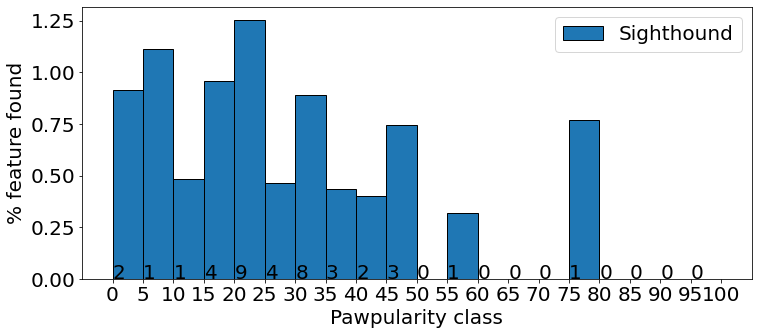

Pearsons correlation: -0.768
P-value: 0.000


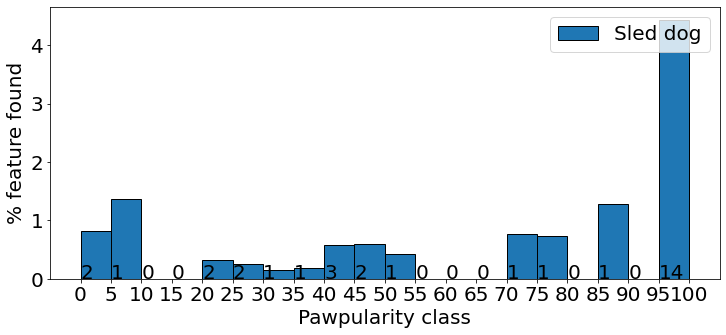

Pearsons correlation: 0.312
P-value: 0.000


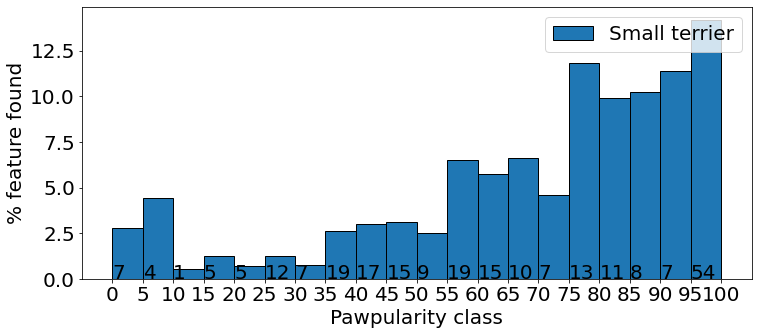

Pearsons correlation: 0.857
P-value: 0.012


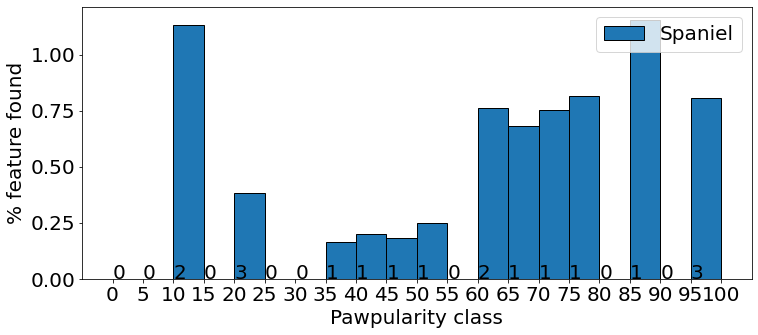

Pearsons correlation: 0.373
P-value: 0.000


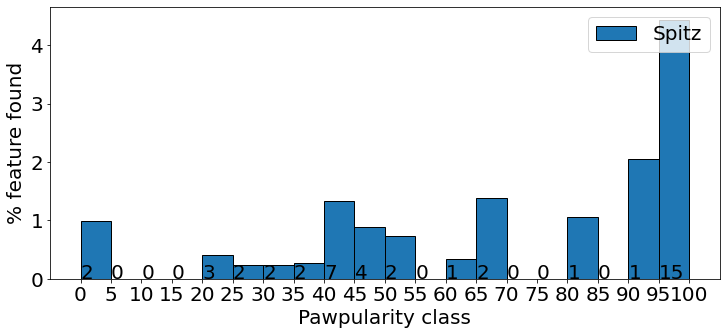

Pearsons correlation: 0.472
P-value: 0.000


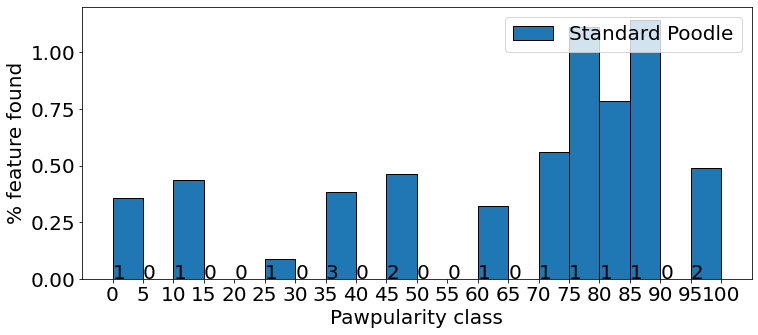

Pearsons correlation: 0.467
P-value: 0.000


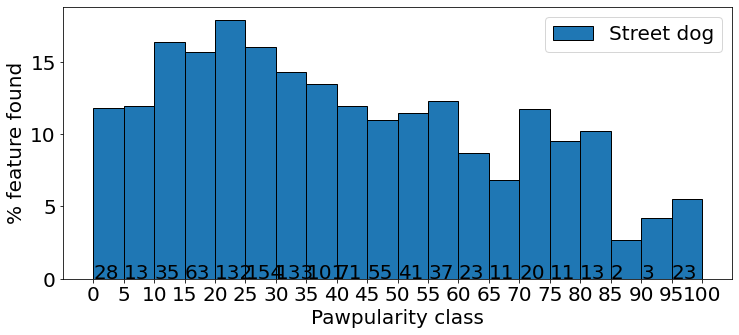

Pearsons correlation: -0.800
P-value: 0.303


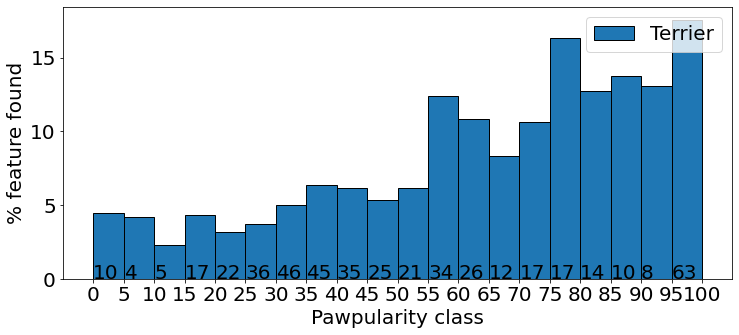

Pearsons correlation: 0.908
P-value: 0.500


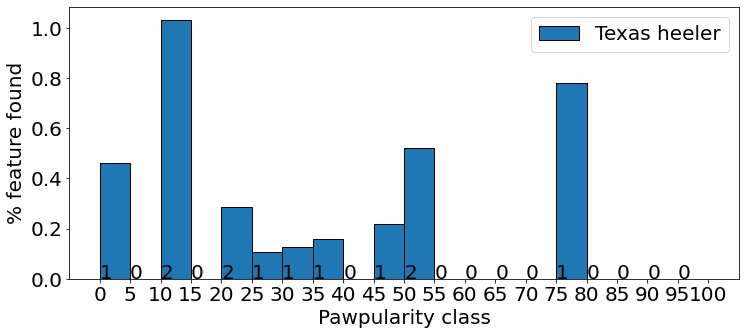

Pearsons correlation: -0.318
P-value: 0.000


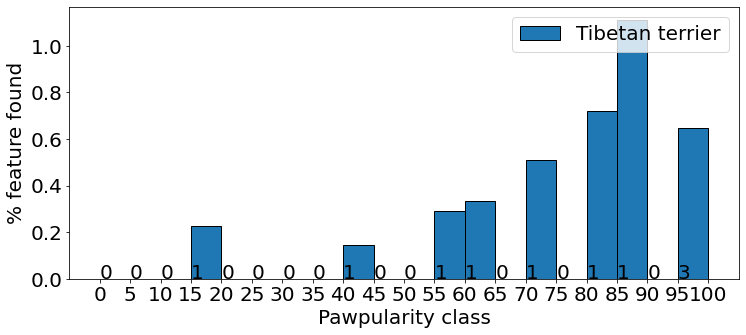

Pearsons correlation: 0.591
P-value: 0.000


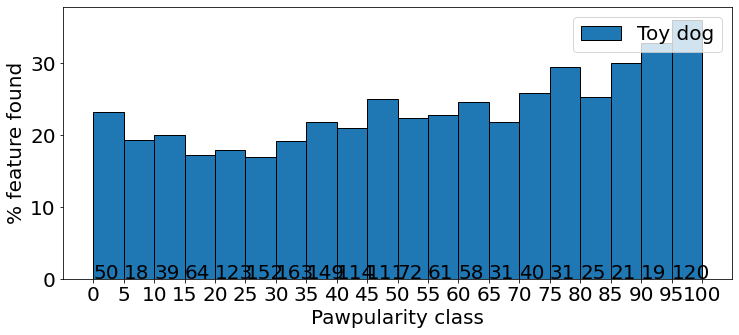

Pearsons correlation: 0.833
P-value: 0.000


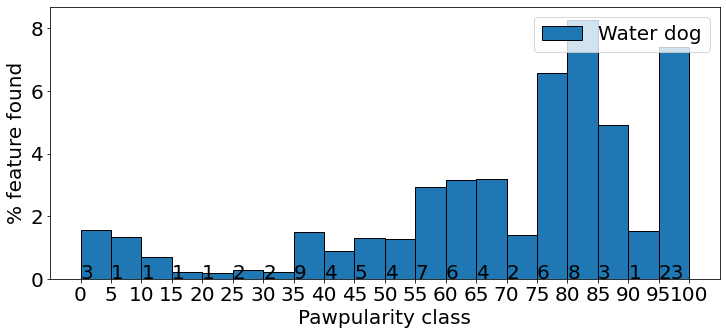

Pearsons correlation: 0.716
P-value: 0.000


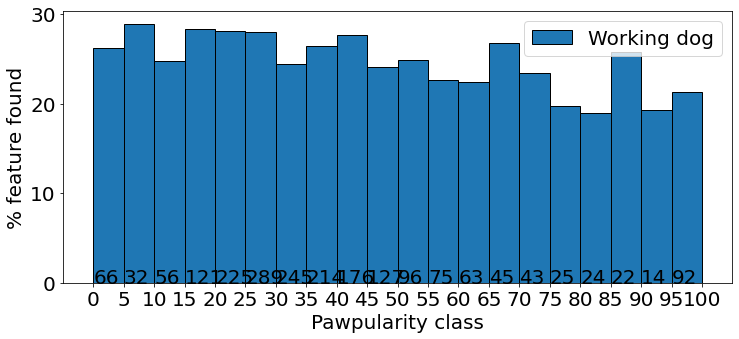

Pearsons correlation: -0.739
P-value: 0.000


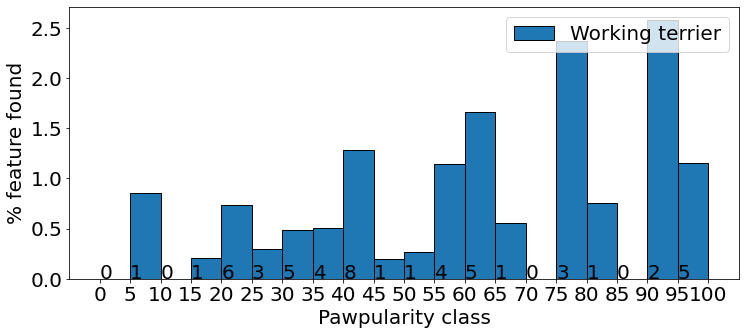

Pearsons correlation: 0.467
P-value: 0.000


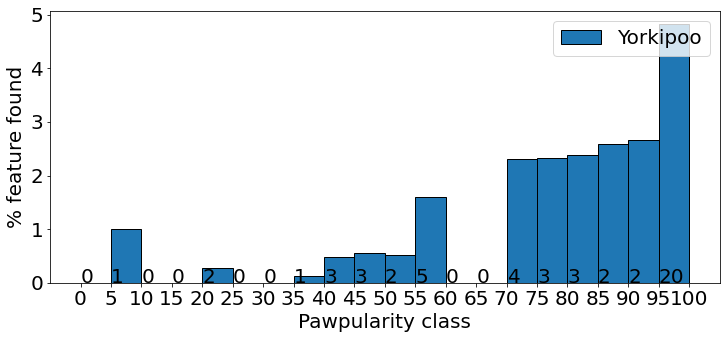

Pearsons correlation: 0.778
P-value: 0.000


In [18]:
for dog in dogs:
    auto_feature_plot(dog, dogs_data)

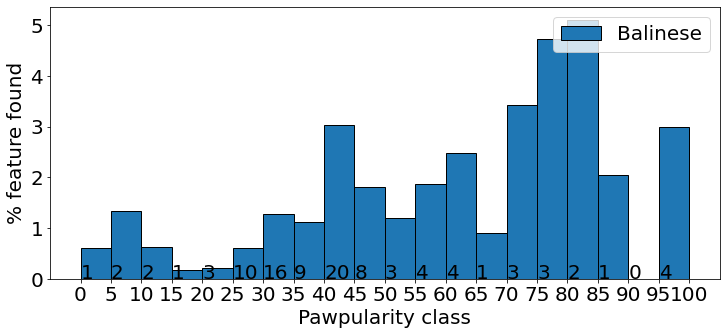

Pearsons correlation: 0.558
P-value: 0.000


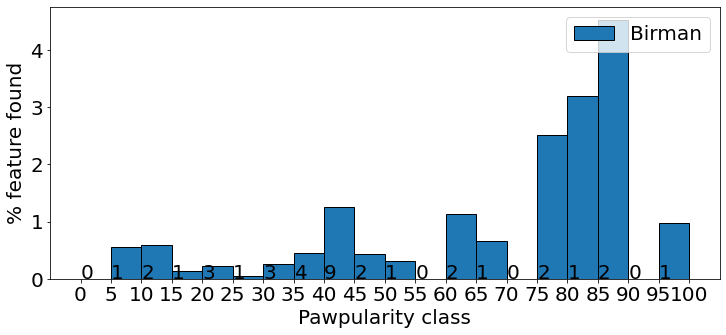

Pearsons correlation: 0.498
P-value: 0.000


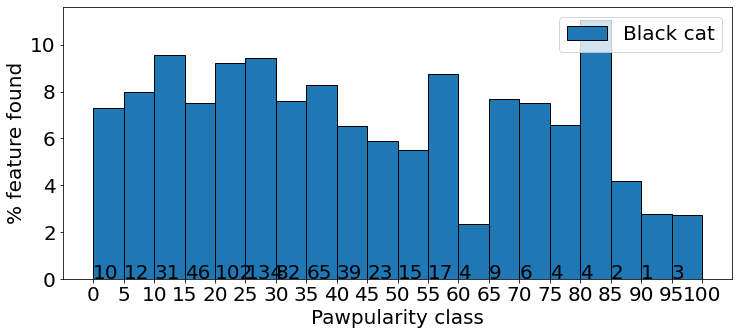

Pearsons correlation: -0.514
P-value: 0.079


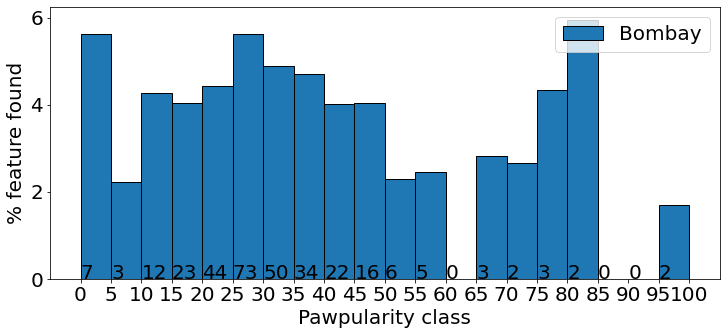

Pearsons correlation: -0.533
P-value: 0.000


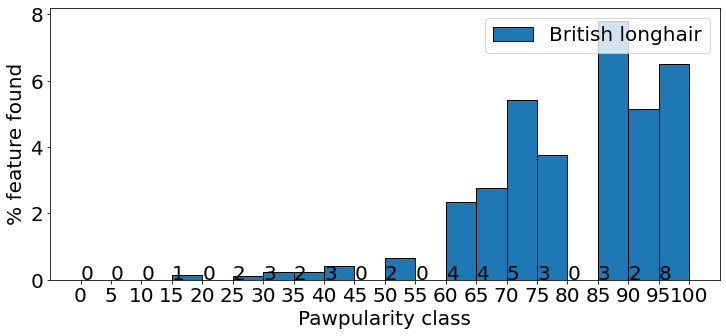

Pearsons correlation: 0.771
P-value: 0.000


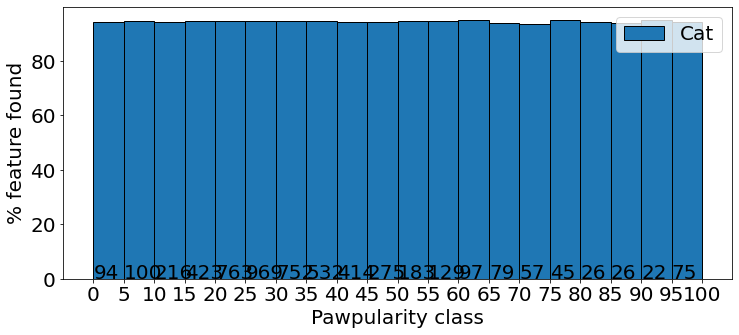

Pearsons correlation: -0.176
P-value: 0.000


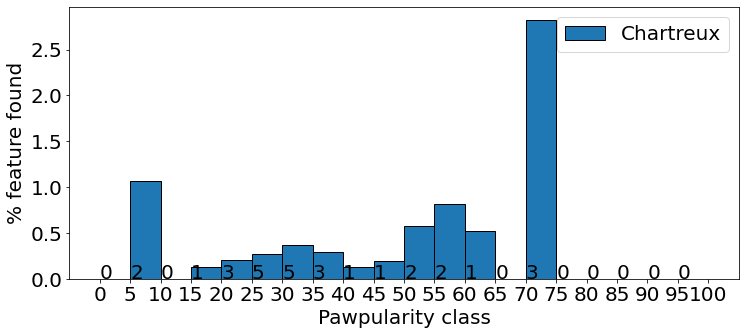

Pearsons correlation: 0.013
P-value: 0.000


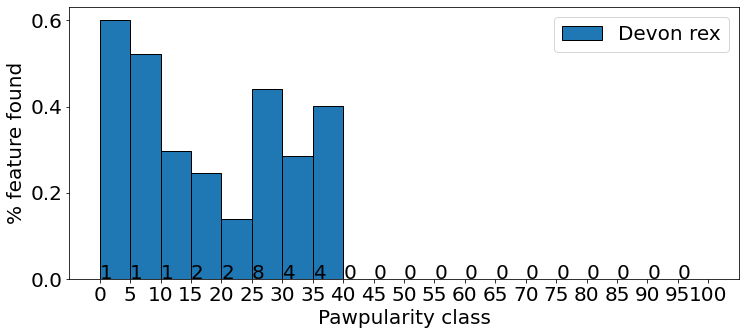

Pearsons correlation: -0.807
P-value: 0.000


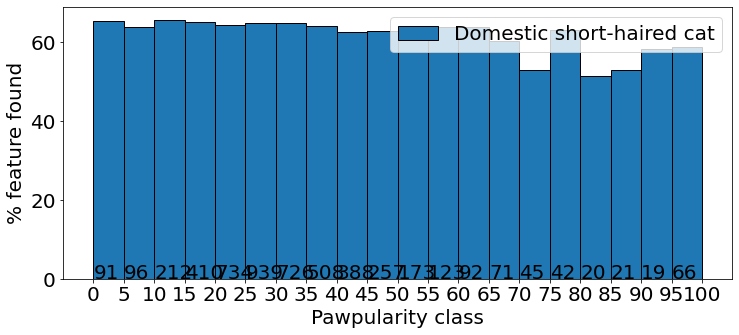

Pearsons correlation: -0.743
P-value: 0.000


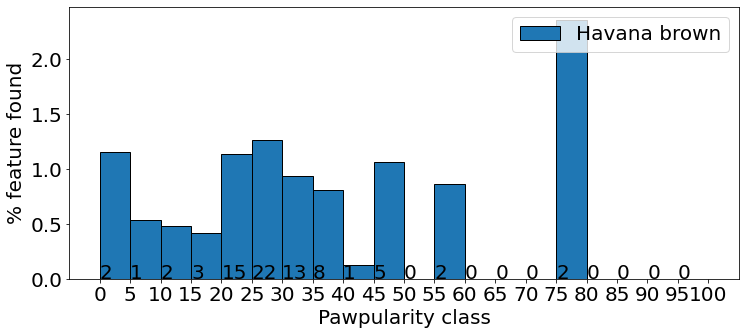

Pearsons correlation: -0.358
P-value: 0.000


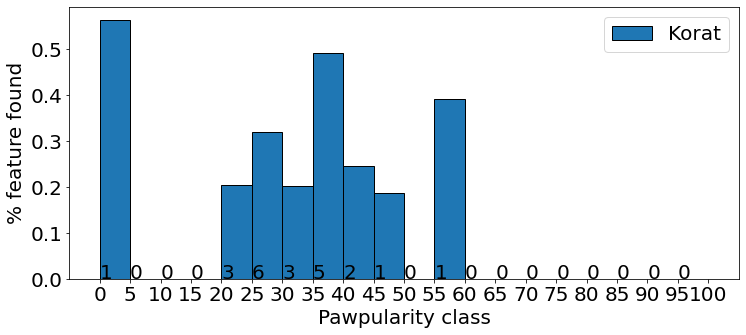

Pearsons correlation: -0.467
P-value: 0.000


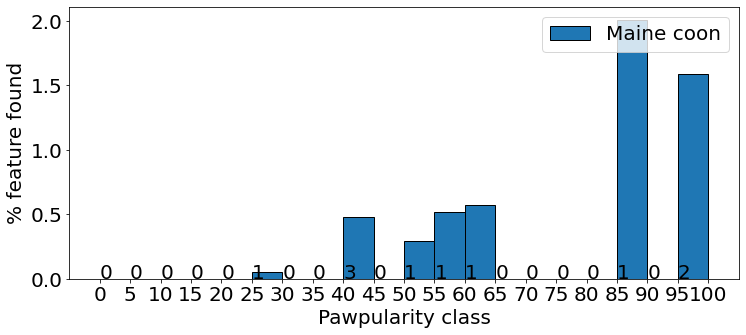

Pearsons correlation: 0.502
P-value: 0.000


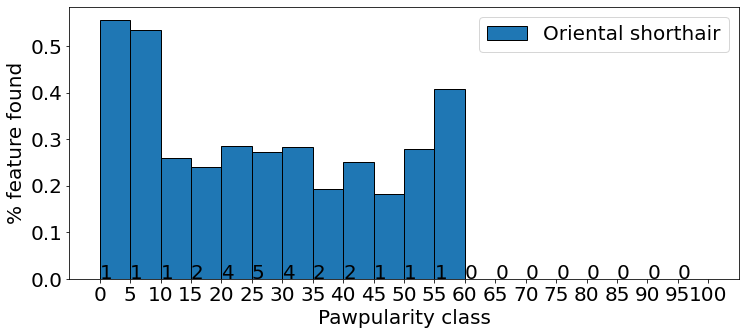

Pearsons correlation: -0.845
P-value: 0.000


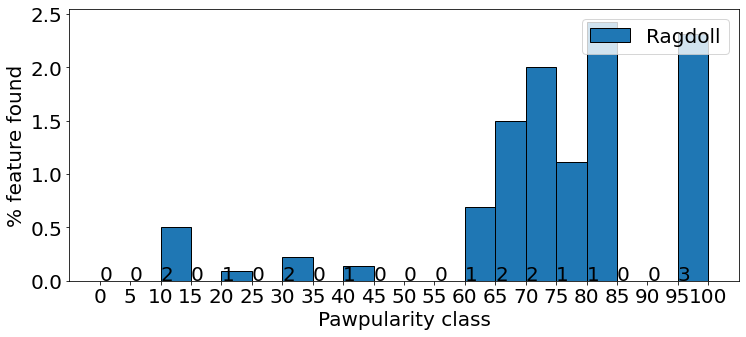

Pearsons correlation: 0.576
P-value: 0.000


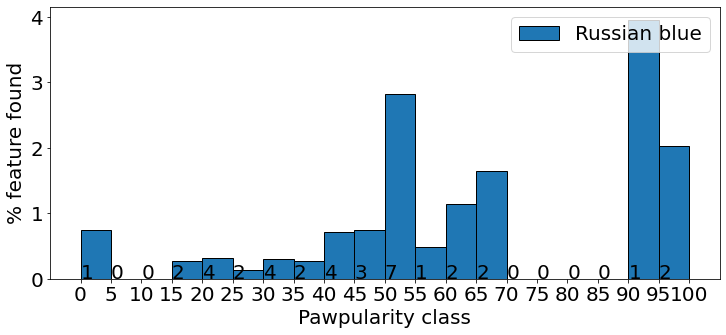

Pearsons correlation: 0.408
P-value: 0.000


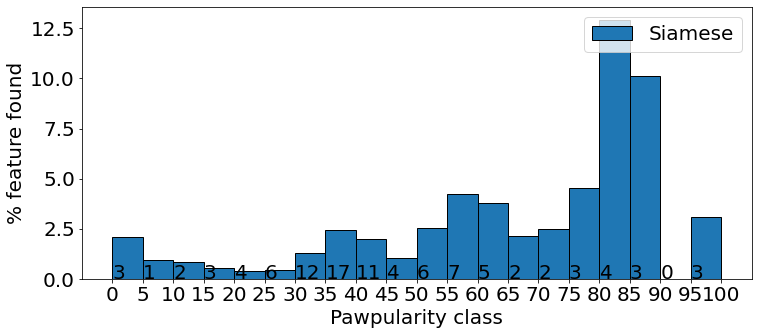

Pearsons correlation: 0.532
P-value: 0.000


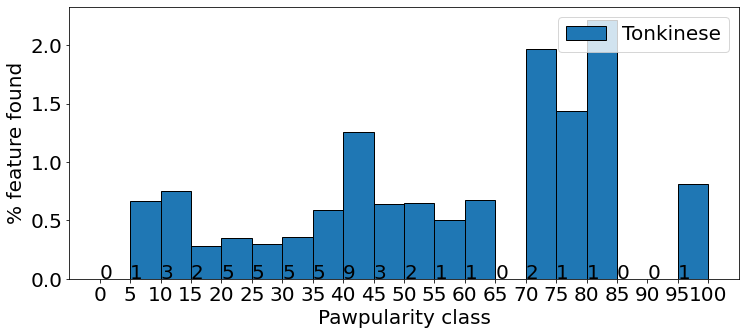

Pearsons correlation: 0.291
P-value: 0.000


In [19]:
for cat in cats:
    auto_feature_plot(cat, cats_data)

In [16]:
# Calculates the Pearson correlations for each feature in the list
def calc_correlations(features, data):
  correlations = []
  for f in features:
      values = analyse_feature_20(f, data)
      if not too_small(values):
        xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]   
        corr, _ = pearsonr(xy[0], xy[1])
        p = ttest_ind(xy[0], xy[1]).pvalue
        correlations.append((f, corr, p))
  return correlations

def calc_correlations_100(features, data):
  correlations = []
  for f in features:
      values = analyse_feature_100(f, data)
      if not too_small(values):
        xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]   
        corr, _ = pearsonr(xy[0], xy[1])
        p = ttest_ind(xy[0], xy[1]).pvalue
        correlations.append((f, corr, p))
  return correlations

def calc_correlations_10(features, data):
  correlations = []
  for f in features:
      values = analyse_feature_10(f, data)
      if not too_small(values):
        xy = [[i for i,j,k in values], [j for i,j,k in values], [k for i,j,k in values]]   
        corr, _ = pearsonr(xy[0], xy[1])
        p = ttest_ind(xy[0], xy[1]).pvalue
        correlations.append((f, corr, p))
  return correlations

In [ ]:
dog_correlations = calc_correlations(dogs, dogs_data)
print(dog_correlations)

In [37]:
df_dogs = pd.DataFrame(dog_correlations, columns = ['Feature', 'Correlation', 'P-value'])
display(df_dogs)

Feature  Correlation       P-value
0                      Beagle     0.387656  3.955676e-08
1              Beagle-harrier     0.414741  2.379735e-08
2                    Beaglier     0.465170  3.658057e-08
3   Belgian shepherd malinois     0.490038  2.250144e-08
4                      Bichon     0.452316  2.245676e-08
..                        ...          ...           ...
64                    Toy dog     0.833005  1.064186e-09
65                  Water dog     0.716236  1.663587e-05
66                Working dog    -0.739288  2.569087e-12
67            Working terrier     0.467360  9.784370e-08
68                   Yorkipoo     0.777992  2.986917e-07

[69 rows x 3 columns]

In [ ]:
cat_correlations = calc_correlations(cats, cats_data)
print(cat_correlations)

In [39]:
df_cats = pd.DataFrame(cat_correlations, columns = ['Feature', 'Correlation', 'P-value'])
display(df_cats)

Feature  Correlation       P-value
0                    Balinese     0.557713  1.628907e-06
1                      Birman     0.497763  1.626576e-07
2                   Black cat    -0.513827  7.883856e-02
3                      Bombay    -0.533467  6.889423e-05
4            British longhair     0.771469  4.289086e-06
5                         Cat    -0.175654  2.521880e-40
6                   Chartreux     0.012546  3.805645e-08
7                   Devon rex    -0.807377  2.001128e-08
8   Domestic short-haired cat    -0.743311  6.766234e-29
9                Havana brown    -0.358301  5.872256e-08
10                      Korat    -0.466989  1.921246e-08
11                 Maine coon     0.501751  2.948433e-08
12         Oriental shorthair    -0.844929  2.196153e-08
13                    Ragdoll     0.576159  6.326291e-08
14               Russian blue     0.407967  1.223684e-07
15                    Siamese     0.531637  9.040483e-05
16                  Tonkinese     0.290855  7.677781e-08

In [ ]:
features = data.Feature.tolist()
features = sorted(list(set(features)))
print(features)

In [42]:
cat_correlations = calc_correlations(features, cats_data)
cat_correlations_df = pd.DataFrame(cat_correlations, columns = ['Feature', 'Correlation', 'P-value'])
display(cat_correlations_df)

Feature  Correlation       P-value
0               Abdomen     0.298909  2.981635e-08
1            Adaptation    -0.450912  6.151534e-08
2           Advertising    -0.325340  4.168924e-08
3    Ancient dog breeds     0.320380  2.909963e-08
4           Animal feed    -0.238722  7.311669e-08
..                  ...          ...           ...
391                Yard    -0.172525  2.082984e-08
392                Yawn     0.379819  2.443476e-08
393              Yellow    -0.452892  3.064657e-08
394                 Zoo    -0.707734  2.233413e-08
395        studio couch     0.185714  1.758623e-08

[396 rows x 3 columns]

In [43]:
dog_correlations = calc_correlations(features, dogs_data)
dog_correlations_df = pd.DataFrame(dog_correlations, columns = ['Feature', 'Correlation', 'P-value'])
display(dog_correlations_df)

Feature  Correlation       P-value
0               Abdomen     0.196090  2.852092e-08
1            Adaptation     0.107749  2.457229e-08
2             Adventure    -0.696143  1.679259e-07
3           Advertising    -0.248969  7.090872e-08
4    Ancient dog breeds     0.100473  1.836368e-06
..                  ...          ...           ...
414                Yard    -0.236122  5.463084e-08
415                Yawn     0.174011  1.843879e-08
416              Yellow     0.348791  4.377222e-08
417            Yorkipoo     0.777992  2.986917e-07
418                 Zoo     0.215811  2.307464e-08

[419 rows x 3 columns]

In [18]:
# Function that displays the n-th photo of a certain feature
def img_feature(n, feature, data):
  df = data[data['Feature'] == feature]
  img_loc = '/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/'+df.Id.iloc[n]+'.jpg'
  print(img_loc)
  print('Pawpularity:', df.Pawpularity.iloc[n])
  %matplotlib inline
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  plt.imshow(mpimg.imread(img_loc))
  plt.show()

/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/5bc4ff3cbbd39a6b3444f2453eeb5b6a.jpg
Pawpularity: 7


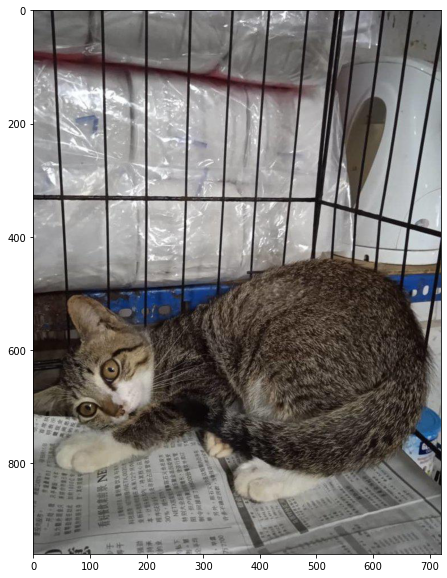

/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/a79648b65f21914aa40478346272a160.jpg
Pawpularity: 52


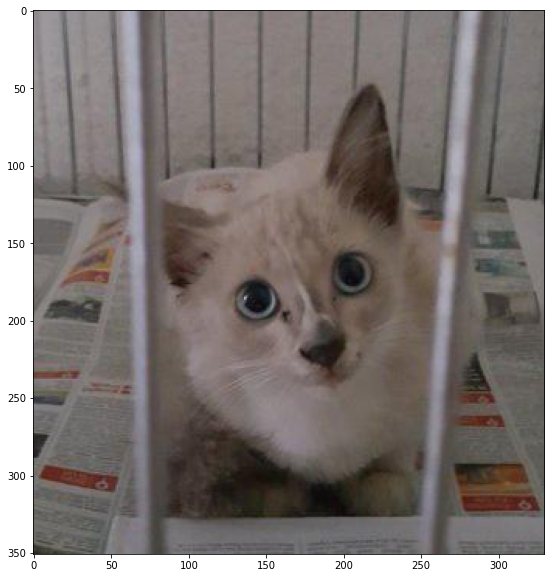

/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/cd1740b10ef465b6471fd0fde9d24e0f.jpg
Pawpularity: 14


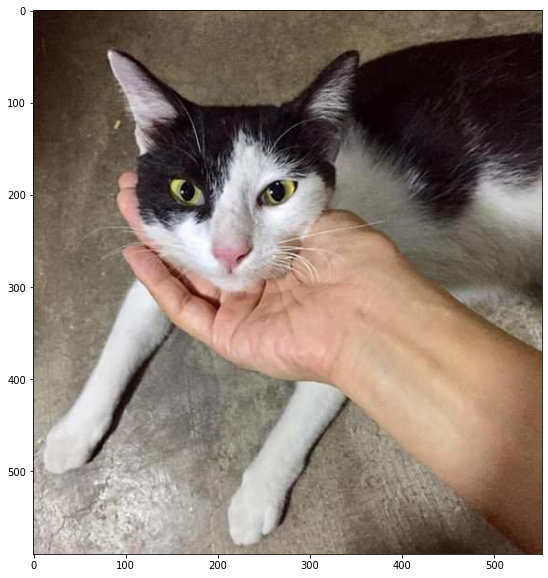

/content/drive/MyDrive/TxMM/petfinder-pawpularity-score/train/a2c1f071b504550289f9116f52968548.jpg
Pawpularity: 32


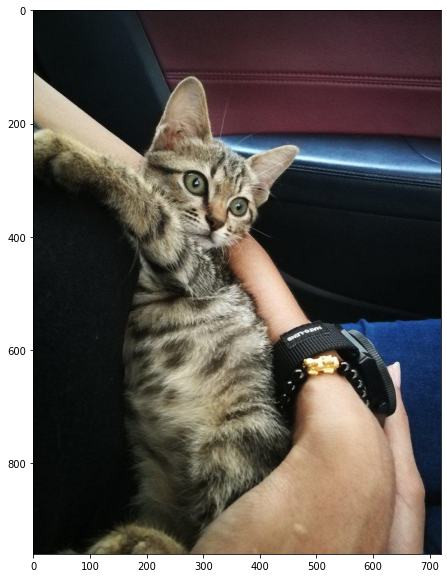

In [43]:
# Least popular photo with a detected 'Newspaper'
img_feature(0, 'Newspaper', cats_data)

# Most popular photo with a detected 'Newspaper'
img_feature(28, 'Newspaper', cats_data)

#Random photo with a 'Human body'
img_feature(30, 'Human body', data)

# Random photo with a 'Human body'
img_feature(50, 'Human body', data)

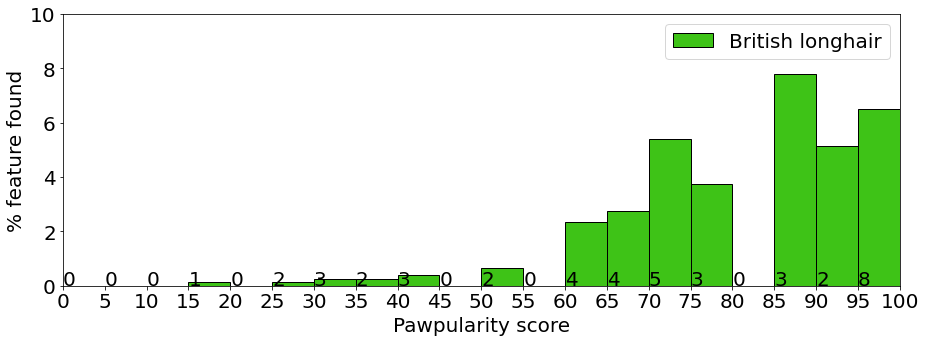

Data points: 42
Pearsons correlation: 0.771
P-value: 0.000


In [117]:
feature_plot('British longhair', cats_data, '#3EC317', 0, 10)

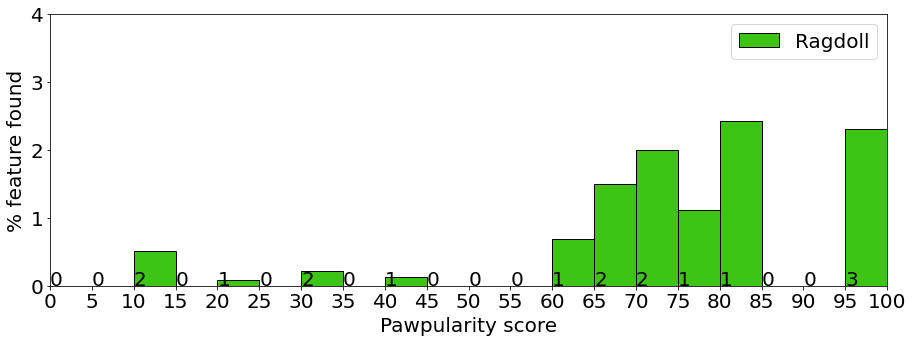

Data points: 16
Pearsons correlation: 0.576
P-value: 0.000


In [119]:
feature_plot('Ragdoll', cats_data, '#3EC317', 0, 4)

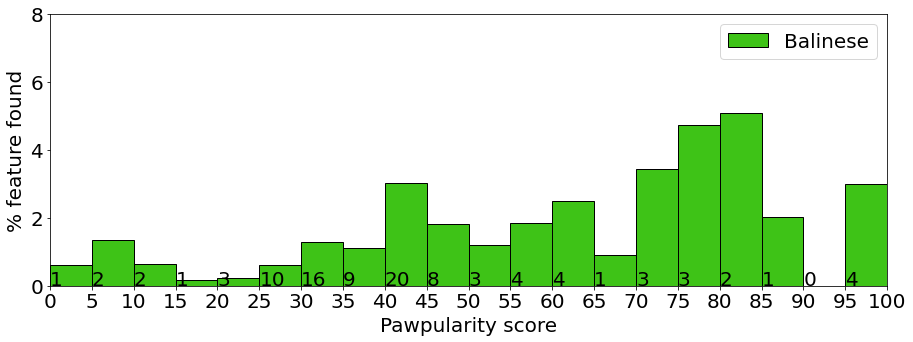

Data points: 97
Pearsons correlation: 0.558
P-value: 0.000


In [120]:
feature_plot('Balinese', cats_data, '#3EC317', 0, 8)

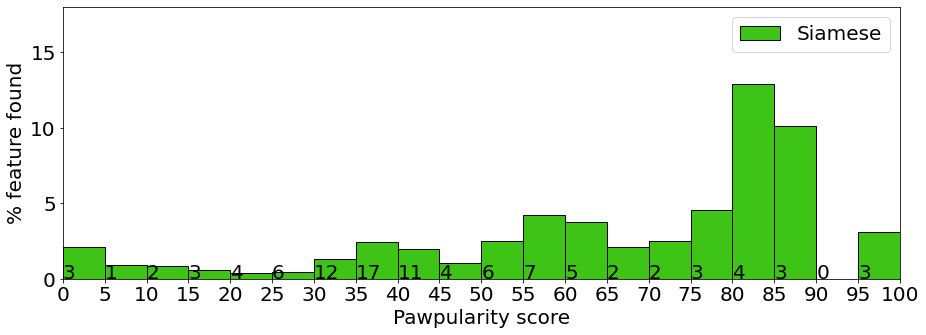

Data points: 98
Pearsons correlation: 0.532
P-value: 0.000


In [121]:
feature_plot('Siamese', cats_data, '#3EC317', 0, 18)

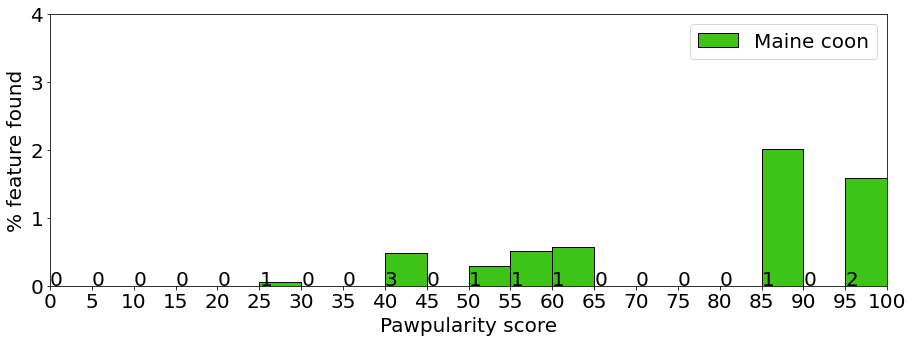

Data points: 10
Pearsons correlation: 0.502
P-value: 0.000


In [122]:
feature_plot('Maine coon', cats_data, '#3EC317', 0, 4)

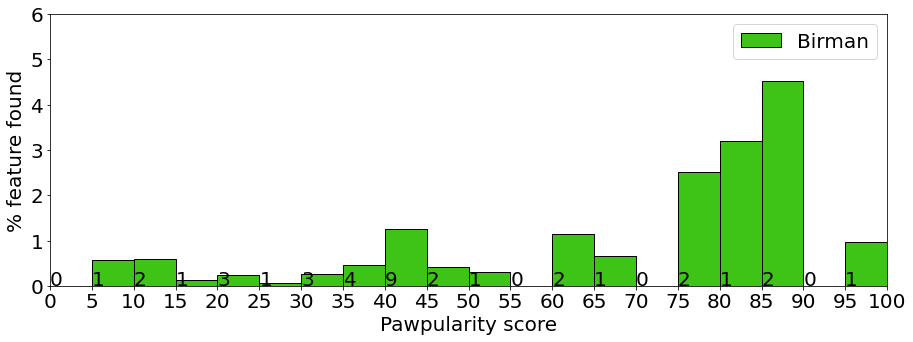

Data points: 36
Pearsons correlation: 0.498
P-value: 0.000


In [123]:
feature_plot('Birman', cats_data, '#3EC317', 0, 6)

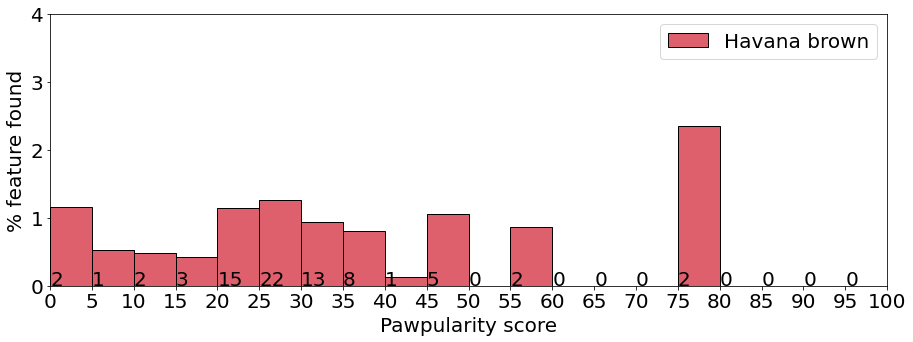

Data points: 76
Pearsons correlation: -0.358
P-value: 0.000


In [125]:
feature_plot('Havana brown', cats_data, '#de606c', 0, 4)

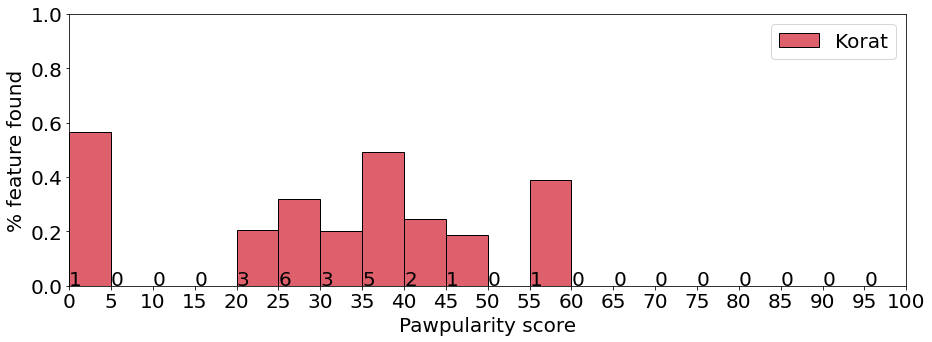

Data points: 22
Pearsons correlation: -0.467
P-value: 0.000


In [126]:
feature_plot('Korat', cats_data, '#de606c', 0, 1)

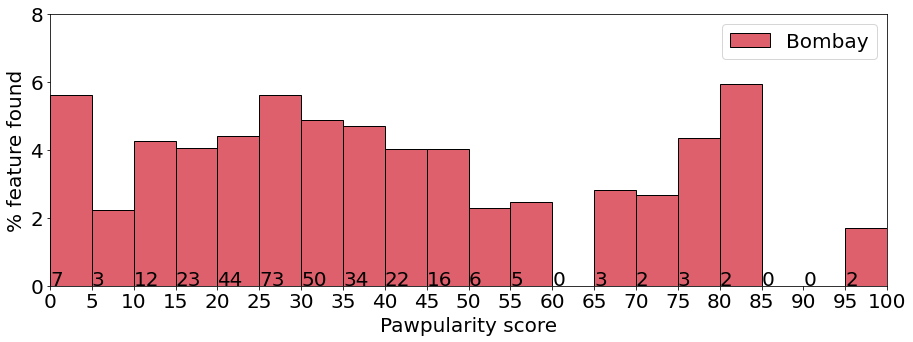

Data points: 307
Pearsons correlation: -0.533
P-value: 0.000


In [128]:
feature_plot('Bombay', cats_data, '#de606c', 0, 8)

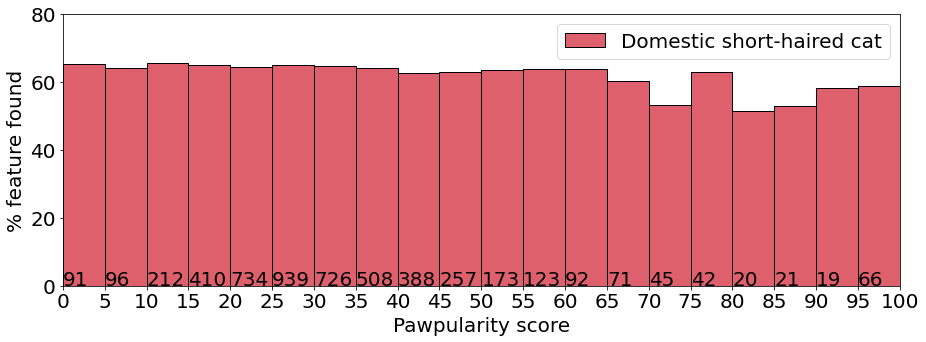

Data points: 5033
Pearsons correlation: -0.743
P-value: 0.000


In [129]:
feature_plot('Domestic short-haired cat', cats_data, '#de606c', 0, 80)

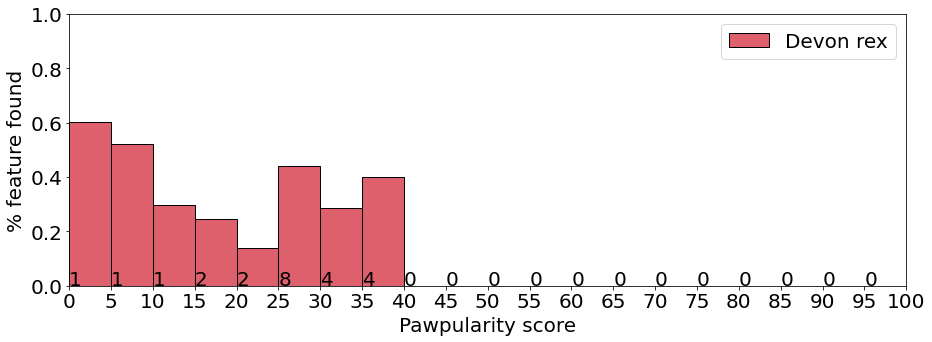

Data points: 23
Pearsons correlation: -0.807
P-value: 0.000


In [130]:
feature_plot('Devon rex', cats_data, '#de606c', 0, 1)

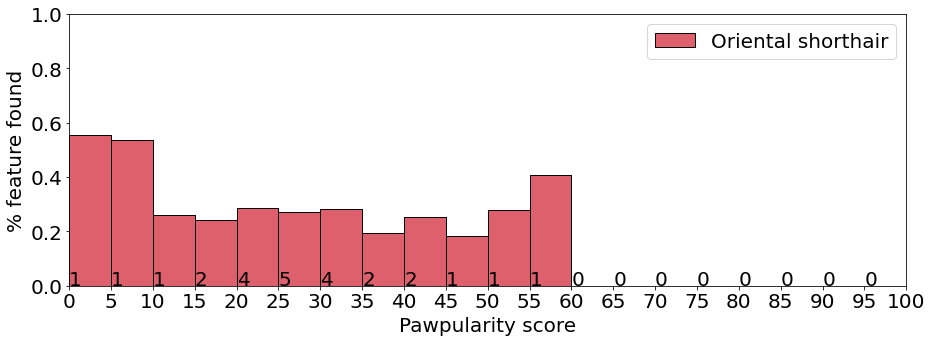

Data points: 25
Pearsons correlation: -0.845
P-value: 0.000


In [131]:
feature_plot('Oriental shorthair', cats_data, '#de606c', 0, 1)

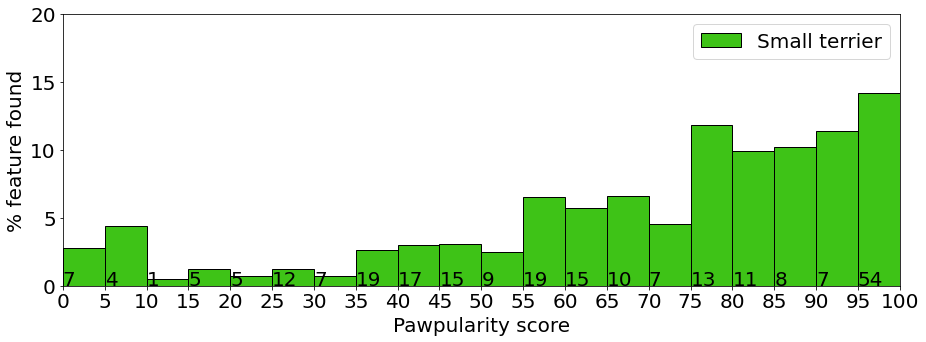

Data points: 245
Pearsons correlation: 0.857
P-value: 0.012


In [133]:
feature_plot('Small terrier', dogs_data, '#3EC317', 0, 20)

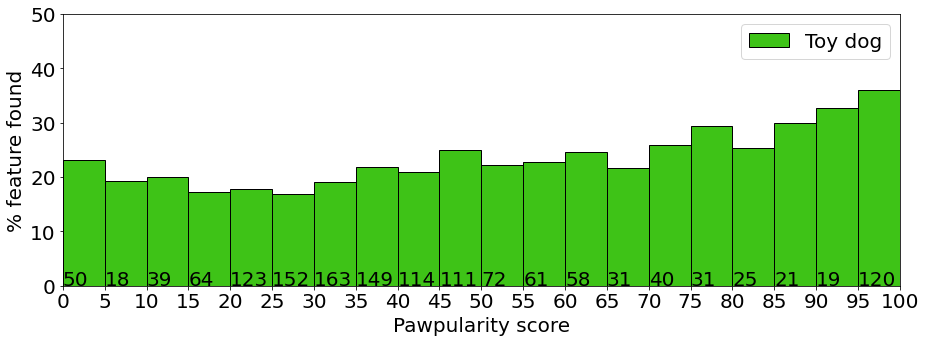

Data points: 1461
Pearsons correlation: 0.833
P-value: 0.000


In [134]:
feature_plot('Toy dog', dogs_data, '#3EC317', 0, 50)

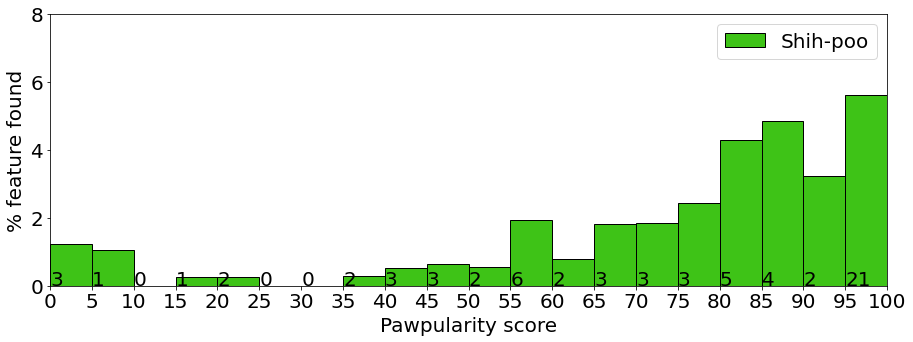

Data points: 66
Pearsons correlation: 0.800
P-value: 0.000


In [135]:
feature_plot('Shih-poo', dogs_data, '#3EC317', 0, 8)

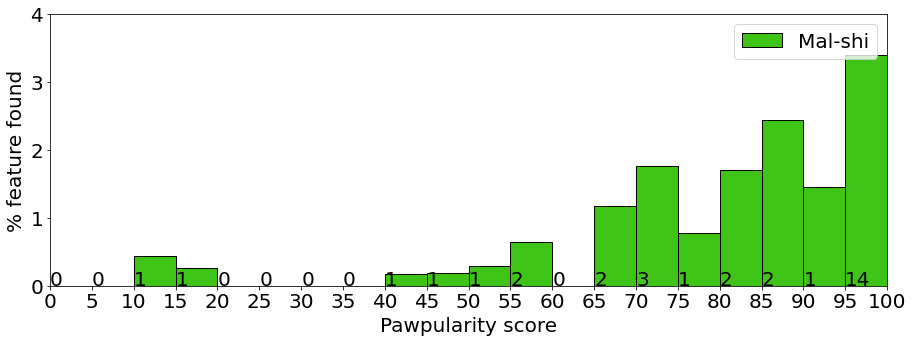

Data points: 32
Pearsons correlation: 0.796
P-value: 0.000


In [136]:
feature_plot('Mal-shi', dogs_data, '#3EC317', 0, 4)

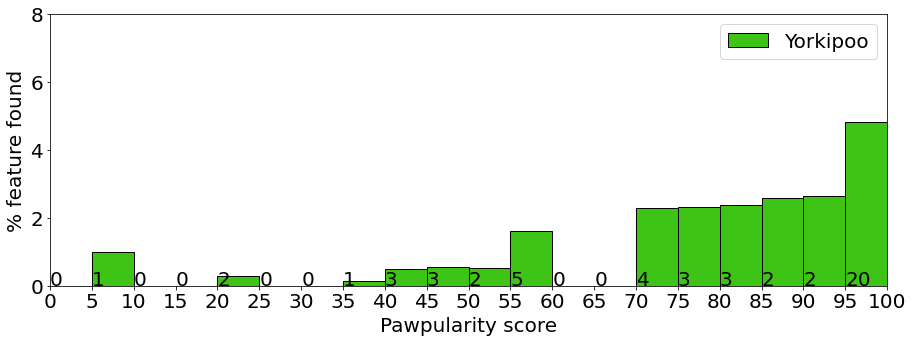

Data points: 51
Pearsons correlation: 0.778
P-value: 0.000


In [137]:
feature_plot('Yorkipoo', dogs_data, '#3EC317', 0, 8)

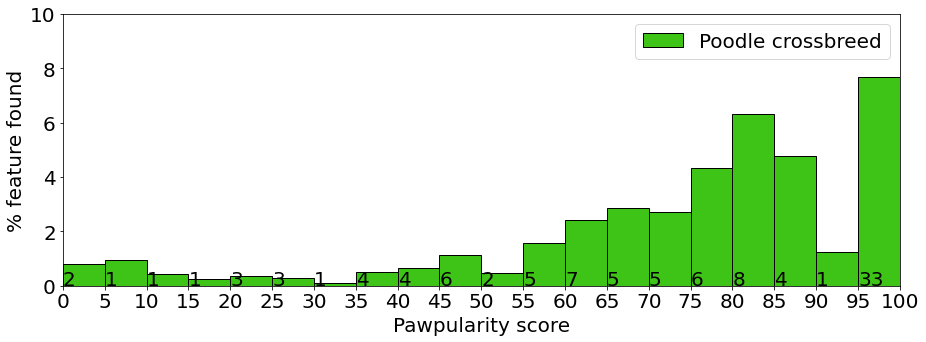

Data points: 102
Pearsons correlation: 0.766
P-value: 0.000


In [138]:
feature_plot('Poodle crossbreed', dogs_data, '#3EC317', 0, 10)

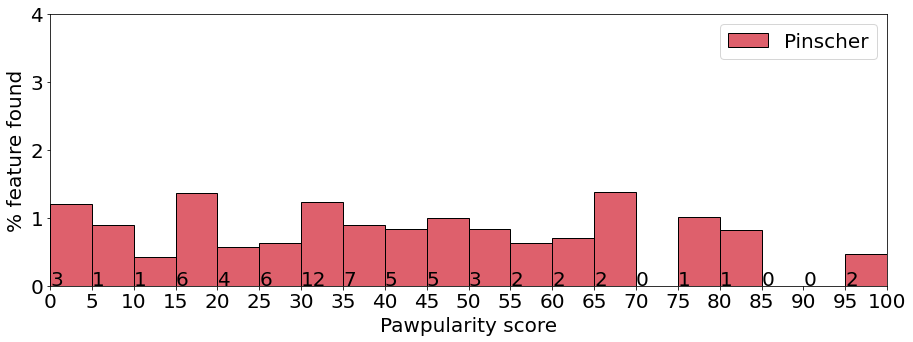

Data points: 63
Pearsons correlation: -0.465
P-value: 0.000


In [152]:
feature_plot('Pinscher', dogs_data, '#de606c', 0, 4)

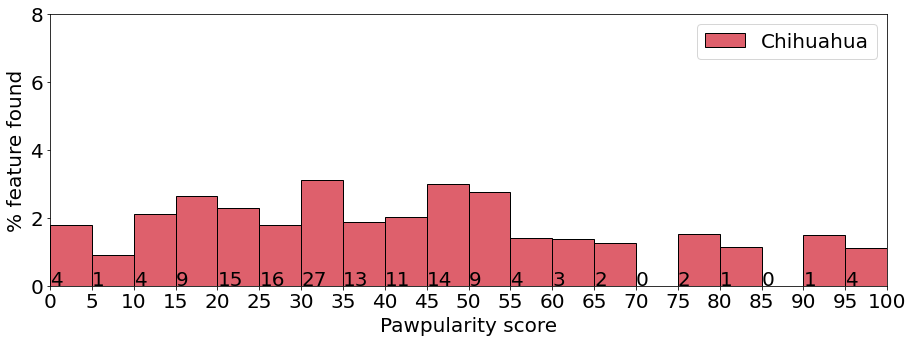

Data points: 140
Pearsons correlation: -0.499
P-value: 0.000


In [150]:
feature_plot('Chihuahua', dogs_data, '#de606c', 0, 8)

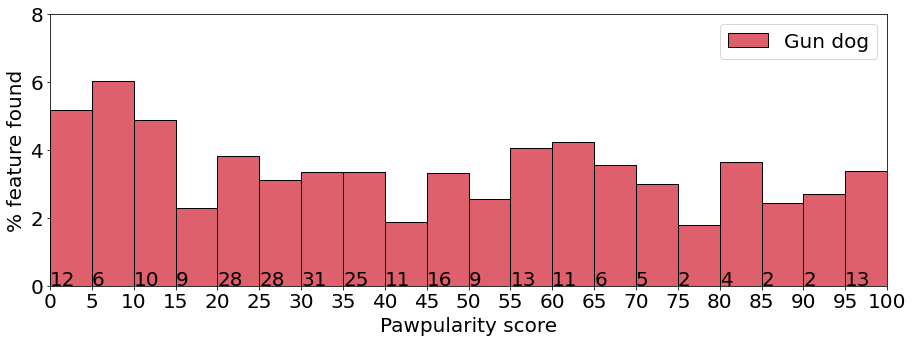

Data points: 243
Pearsons correlation: -0.501
P-value: 0.000


In [139]:
feature_plot('Gun dog', dogs_data, '#de606c', 0, 8)

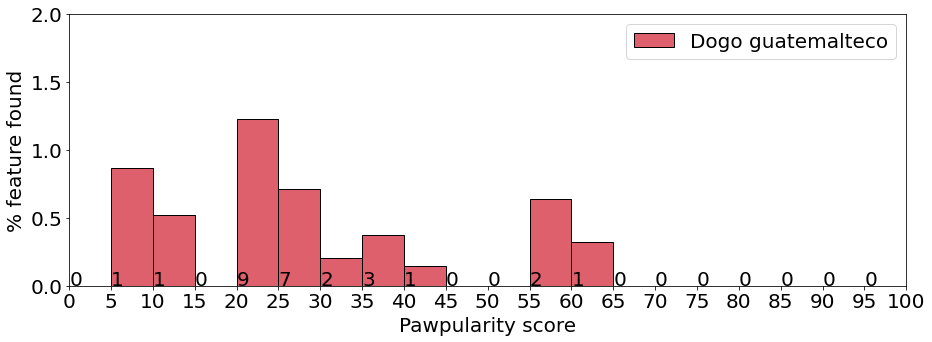

Data points: 27
Pearsons correlation: -0.524
P-value: 0.000


In [140]:
feature_plot('Dogo guatemalteco', dogs_data, '#de606c', 0, 2)

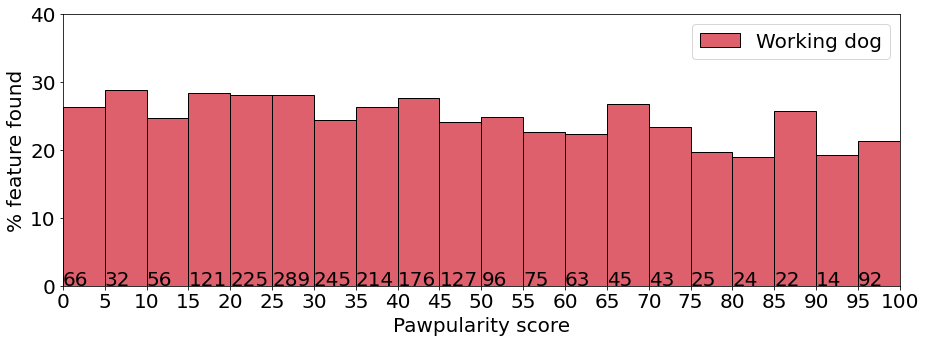

Data points: 2050
Pearsons correlation: -0.739
P-value: 0.000


In [141]:
feature_plot('Working dog', dogs_data, '#de606c', 0, 40)

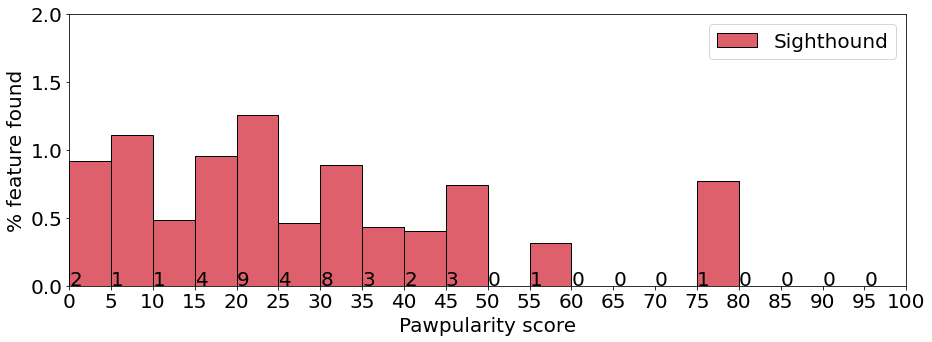

Data points: 39
Pearsons correlation: -0.768
P-value: 0.000


In [142]:
feature_plot('Sighthound', dogs_data, '#de606c', 0, 2)